### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT25/AMT25/HPLC/"
DIN_acs = "/users/rsg/tjor/scratch_network/AMT_underway/AMT25/Processed/UWay/Step3/"

In [6]:
fn_hplc =  "AMT_25_Pigments.xlsx"
fn_meta = "Filtering-Log-HPLC-AMT25_reformat.xlsx"
fn_optics = "amt25_final.nc"

In [7]:
print(DIN_hplc + fn_hplc)

df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "BODC_submission_template", header = 16, engine = 'openpyxl', nrows=130)
df_hplc.keys()

#list(df_hplc['Sample name'])
df_hplc.rename(columns={'Sample name': 'Label'}, inplace = True)

df_hplc.keys()
print(df_hplc['Label'])
#acs_filtered2 = acs_filtered


# df_hplc

/data/datasets/cruise_data/active/AMT25/AMT25/HPLC/AMT_25_Pigments.xlsx
0        AMT25-001-2A
1        AMT25-001-2B
2       AMT25-001-25A
3        AMT25-002-2A
4       AMT25-002-37A
            ...      
125      AMT25-063-2A
126    AMT25-063-135A
127      AMT25-064-2A
128    AMT25-064-120A
129      AMT25-065-2A
Name: Label, Length: 130, dtype: object


In [8]:

print(DIN_hplc + fn_meta)
df_meta = pd.read_excel(DIN_hplc + fn_meta, header = 0)
df_meta.keys()
list(df_meta['NAME'])


label = []; # match sample/name ID between meta and hplc file
for i in range(len(df_meta)):
    old_string = (str(df_meta['NAME'][i]))
    new_string = old_string.replace(":", "" )
    label.append(new_string)

df_meta['Label'] = label


#print(df_meta['Label'])

/data/datasets/cruise_data/active/AMT25/AMT25/HPLC/Filtering-Log-HPLC-AMT25_reformat.xlsx


In [9]:
# merge two tables to extract info from df_meta

print(df_hplc['Label'])
print(df_meta['Label'])

df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])

sorted(df_hplc.keys())

0        AMT25-001-2A
1        AMT25-001-2B
2       AMT25-001-25A
3        AMT25-002-2A
4       AMT25-002-37A
            ...      
125      AMT25-063-2A
126    AMT25-063-135A
127      AMT25-064-2A
128    AMT25-064-120A
129      AMT25-065-2A
Name: Label, Length: 130, dtype: object
0      AMT25-261-0726-UND
1            AMT25-001-2A
2            AMT25-001-2B
3           AMT25-001-25A
4           AMT25-001-25B
              ...        
372          AMT25-076-5A
373          AMT25-076-5B
374         AMT25-076-40A
375         AMT25-076-40B
376    AMT25-306-1703-UND
Name: Label, Length: 377, dtype: object


[' [Chl c2MGDG-1]',
 ' [Chl c2MGDG-2]',
 'BOTTLE NO',
 'CRYOBOX HPLC',
 'CTD',
 'Cruise Name',
 'Depth (meters)',
 'Filter diameter (mm)',
 'Filter storage before analysis',
 'Filter type',
 'LAT',
 'LON',
 'Label',
 'N = Other, S = Surface; D = DCM',
 'NAME',
 'NOTES',
 'Name of Water Body',
 'REPLICATE (A = NO, B = YES)',
 'SAMPLE DETPH (m)',
 'SDY',
 'STATION',
 'Sample Collector',
 'TIME (GMT)',
 'Unnamed: 15',
 'Unnamed: 5',
 'VARIABLE',
 'VOLUME (l)',
 'Volume filtered (L)',
 '[Allo]',
 '[Anth]',
 '[Asta]',
 '[But fuco]',
 '[Caro]',
 '[Chl a]',
 '[Chl b] + [DVChl b]',
 '[Chl c1]',
 '[Chl c2]',
 '[Chl-c3]',
 '[Chlide a]',
 '[DVChl a]',
 '[Diad]',
 '[Diato]',
 '[Fuco]',
 '[Hex fuco]',
 '[Lut]',
 '[MgDVP]',
 '[Neo]',
 '[PPC]',
 '[PPC]/[Tpig]',
 '[PSC]',
 '[PSP]',
 '[PSP]/[TPig]',
 '[Perid]',
 '[Pras]',
 '[TAcc]',
 '[TAcc]/[Tchla]',
 '[TChl a]',
 '[TChl a]/[TPig]',
 '[TChl b]',
 '[TChl c]',
 '[TChl]',
 '[TPig]',
 '[Viola]',
 '[Zea]',
 '[ββ-Car]',
 '[βε-Car]',
 'blank intentionally']

In [10]:
# convert PML pigment names to NASA pigment names for submission
#                            PML  :  NASA


pml2nasa = {            
                          "[Allo]":"Allo",
                          "[Asta]": "Asta",
                          "[Anth]": "PML_only_Anth",
                      "[But fuco]":"But-fuco",
                          "[Caro]":"Alpha-beta-Car", # !!!! TO CHECK !!!
                         "[Chl a]":'Chl_a',
             "[Chl b] + [DVChl b]":"PML_only_Chl_b_DVChl_b",
                        '[Chl c1]':'Chl_c1',
                        '[Chl c2]':'Chl_c2',
                        '[Chl-c3]':'Chl_c3',
                      "[Chlide a]":"Chlide_a",
                          "[Diad]":"Diadino",
                         "[Diato]":"Diato",
                       "[DVChl a]":"DV_Chl_a",
                          "[Fuco]":"Fuco",
                      "[Hex fuco]":"Hex-fuco",
                           "[Lut]":"Lut",
                         '[MgDVP]':'Mg_DVP',
                           '[Neo]':'Neo',
                           "[PPC]":"PPC",
                           "[PSC]":"PSC",
                           "[PSP]":"PSP",
                         "[Perid]":"Perid",
                          "[Pras]":"Pras",
                           "[Zea]":"Zea",
                          "[TAcc]":"Tacc",
                          "[TChl]":"TChl",
                        "[TChl a]":"Tot_Chl_a",
                        "[TChl b]":"Tot_Chl_b",
                        "[TChl c]":"Tot_Chl_c",
                          '[TPig]': "Tpg",
                         '[Viola]':'Viola',
                        '[ββ-Car]':"beta-beta-Car",
                        '[βε-Car]':"beta-epi-Car",                  
            
           }
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
df_hplc = df_hplc.rename(columns = pml2nasa)

# create merged pigments
# "Alpha-beta-Car", 
#df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"] - ALREADY IN MERGED FORMAT
#df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"]) - 
           
# "Chl c1c2"
df_hplc["Chl_c1c2"] = df_hplc["Chl_c2"] + df_hplc["Chl_c1"]  +df_hplc["Mg_DVP"]


# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)   - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
#f_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid
#df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
#df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c  - ALREADY IN MERGED FORMAT
#df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a - ALREADY IN MERGED FORMAT
#df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
derived_pigs = {#"Alpha-beta-Car":"Alpha-beta-Car",
                "Chl_c1c2":"Chl_c1c2",
               # "Tot_Chl_a":"Tot_Chl_a", - already added
               # "Tot_Chl_c":"Tot_Chl_c",
                #"Tchl":"Tchl",
                #"PPC":"PPC",
                #"PSC":"PSC",
                #"PSP":"PSP",
                "Tcar":"Tcar",
                "DP":"DP"      }


# drop pigment ratios 

df_hplc.keys()



Index(['Label', 'Sample Collector', 'Cruise Name', 'Volume filtered (L)',
       'Name of Water Body', 'Unnamed: 5', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'Mg_DVP', ' [Chl c2MGDG-1]',
       ' [Chl c2MGDG-2]', 'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2',
       'Chl_c3', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo', 'Viola',
       'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl', 'PPC',
       'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'SDY', 'STATION', 'CTD', 'BOTTLE NO',
       'SAMPLE DETPH (m)', 'TIME (GMT)', 'LAT', 'LON', 'VARIABLE',
       'VOLUME (l)', 'REPLICATE (A = NO, B = YES)', 'NAME', 'CRYOBOX HPLC',
       'NOTES', 'N = Other, S = Surface; D = DCM', 'U

In [11]:
# drop pigment ratios 
#df_hplc = df_hplc.drop('void1') # redumdant
#df_hplc = df_hplc.drop('[PPC]/[Tpig]') # redumdant
#df_hplc = df_hplc.drop('[PSP]/[TPig]') # redumdant
#df_hplc = df_hplc.drop('[TChl a]/[TPig]') # redumdant

#df_hplc['[TAcc]/[Tchla]'] =[]

In [12]:
# merge dictonaries with names of all pigments
all_pigs = dict(pml2nasa, **derived_pigs)

print(all_pigs)

{'[Allo]': 'Allo', '[Asta]': 'Asta', '[Anth]': 'PML_only_Anth', '[But fuco]': 'But-fuco', '[Caro]': 'Alpha-beta-Car', '[Chl a]': 'Chl_a', '[Chl b] + [DVChl b]': 'PML_only_Chl_b_DVChl_b', '[Chl c1]': 'Chl_c1', '[Chl c2]': 'Chl_c2', '[Chl-c3]': 'Chl_c3', '[Chlide a]': 'Chlide_a', '[Diad]': 'Diadino', '[Diato]': 'Diato', '[DVChl a]': 'DV_Chl_a', '[Fuco]': 'Fuco', '[Hex fuco]': 'Hex-fuco', '[Lut]': 'Lut', '[MgDVP]': 'Mg_DVP', '[Neo]': 'Neo', '[PPC]': 'PPC', '[PSC]': 'PSC', '[PSP]': 'PSP', '[Perid]': 'Perid', '[Pras]': 'Pras', '[Zea]': 'Zea', '[TAcc]': 'Tacc', '[TChl]': 'TChl', '[TChl a]': 'Tot_Chl_a', '[TChl b]': 'Tot_Chl_b', '[TChl c]': 'Tot_Chl_c', '[TPig]': 'Tpg', '[Viola]': 'Viola', '[ββ-Car]': 'beta-beta-Car', '[βε-Car]': 'beta-epi-Car', 'Chl_c1c2': 'Chl_c1c2', 'Tcar': 'Tcar', 'DP': 'DP'}


In [13]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)
        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

In [14]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

date = [dt.strptime('15' + str(df_hplc['SDY'][i]), '%y%j').date() for i in range(len(df_hplc))]
time_inday =  [dt.strptime(str(df_hplc['TIME (GMT)'][i]), '%H:%M:%S').time() for i in range(len(df_hplc))]

# add Time object to Date object to get DateTime object
time = [dt.combine(date[i],time_inday[i]) for i in range(len(df_hplc))]

# create "Time" key in df_hplc
df_hplc['time'] = time

# drop Date and Time
df_hplc = df_hplc.drop(columns = ["SDY", "TIME (GMT)"])
                       
df_hplc = df_hplc.sort_values(by = ['time'])
df_hplc = df_hplc.reset_index(drop = True)

df_hplc.keys()



Index(['Label', 'Sample Collector', 'Cruise Name', 'Volume filtered (L)',
       'Name of Water Body', 'Unnamed: 5', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'Mg_DVP', ' [Chl c2MGDG-1]',
       ' [Chl c2MGDG-2]', 'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2',
       'Chl_c3', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo', 'Viola',
       'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl', 'PPC',
       'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'STATION', 'CTD', 'BOTTLE NO',
       'SAMPLE DETPH (m)', 'LAT', 'LON', 'VARIABLE', 'VOLUME (l)',
       'REPLICATE (A = NO, B = YES)', 'NAME', 'CRYOBOX HPLC', 'NOTES',
       'N = Other, S = Surface; D = DCM', 'Unnamed: 15', 'Chl_c1c

In [15]:
# clean up lat
#tmpla = df_hplc['Lat'].values
#for i,la in enumerate(tmpla):
   # if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
     #   la = la.replace("º", "°")
        
    #    degrees = float(la.split("°")[0]) 
     #   minutes = float(la.split("°")[-1].split("'")[0])
    #    NoS = la.split("°")[-1].split("'")[-1]
     #   sign = -1
      #  if (NoS.upper() == "N"):
          #  sign = 1
       # df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
#tmplo = df_hplc['Lon'].values
#for i,lo in enumerate(tmplo):
 #   if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
  #      lo = lo.replace("º", "°")
        
   #     degrees = float(lo.split("°")[0]) 
    #    minutes = float(lo.split("°")[-1].split("'")[0])
     #   EoW = lo.split("°")[-1].split("'")[-1]
      #  sign = -1
      #  if (EoW.upper() == "E"):
       #     sign = 1
       # df_hplc.at[i, 'Lon'] = sign*(degrees + minutes/60.)
        
df_hplc.rename(columns={'LAT': 'Lat'}, inplace = True)
df_hplc.rename(columns={'LON': 'Lon'}, inplace = True)
print(df_hplc.keys())


Index(['Label', 'Sample Collector', 'Cruise Name', 'Volume filtered (L)',
       'Name of Water Body', 'Unnamed: 5', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'Mg_DVP', ' [Chl c2MGDG-1]',
       ' [Chl c2MGDG-2]', 'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2',
       'Chl_c3', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo', 'Viola',
       'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl', 'PPC',
       'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'STATION', 'CTD', 'BOTTLE NO',
       'SAMPLE DETPH (m)', 'Lat', 'Lon', 'VARIABLE', 'VOLUME (l)',
       'REPLICATE (A = NO, B = YES)', 'NAME', 'CRYOBOX HPLC', 'NOTES',
       'N = Other, S = Surface; D = DCM', 'Unnamed: 15', 'Chl_c1c

In [16]:
df_hplc.index


RangeIndex(start=0, stop=124, step=1)

In [17]:
# remove 1 micron filter data  - not needed for AMT26

#index_keep = [];
#for i in range(len(df_hplc_surf)):
#    if df_hplc_surf["Label"].iloc[i][-6:-1] != 'Micro':
 #       index_keep.append(i) 

#df_hplc_surf = df_hplc_surf.iloc[index_keep]
                        
              
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf

In [18]:


index_keep = [];

for i in range(len(df_hplc)):
    print(df_hplc["Depth (meters)"].iloc[i])
    if  df_hplc["Depth (meters)"].iloc[i] <= 10:
        print(i)
        df_hplc["Depth (meters)"].iloc[i] = 7
        index_keep.append(i) 

df_hplc_surf = df_hplc.iloc[index_keep]
df_hplc_surf = df_hplc_surf.set_index("time")




2
0
2
1
25
2
3
37
2
5
25
2
7
20
2
9
35
2
11
35
2
13
70
2
15
2
16
50
2
18
70
2
20
65
2
22
80
2
24
55
2
26
90
2
28
80
2
30
2
31
2
32
100
2
34
110
5
36
5
37
2
38
115
2
40
140
2
42
136
2
44
135
135
2
47
2
48
117
2
50
120
2
52
105
105
2
55
98
2
57
97
2
59
78
72
2
62
2
63
65
2
65
60
2
67
42
2
69
42
2
71
47
2
73
70
70
38
2
77
2
78
64
2
80
58
2
82
85
2
84
65
2
86
60
2
88
62
2
90
42
65
2
93
2
94
67
2
96
95
2
98
112
2
100
2
101
125
125
2
104
156
2
106
150
160
2
109
2
110
165
2
112
138
2
114
158
2
116
2
117
135
2
119
135
120
2
122
2
123


/tmp/ipykernel_556969/3702327639.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hplc["Depth (meters)"].iloc[i] = 7


In [19]:

index_keep = [];
for i in range(len(df_hplc_surf)):
    if  df_hplc_surf["Tot_Chl_a"].iloc[i] > 0.018:  
        index_keep.append(i) 
    else:
       print(i)
        
print(len(df_hplc_surf))
index_keep

df_hplc_surf = df_hplc_surf.iloc[index_keep]
        





38
59
65


In [20]:
len(df_hplc_surf)

63

In [21]:
#type(index_drop)
#df_hplc_surf.drop(index_drop,axis=0)
             
print(df_hplc_surf)

                            Label Sample Collector Cruise Name  \
time                                                             
2015-09-18 07:55:00  AMT25-001-2A       Bob Brewin       AMT25   
2015-09-18 07:55:00  AMT25-001-2B       Bob Brewin       AMT25   
2015-09-19 04:09:00  AMT25-002-2A       Bob Brewin       AMT25   
2015-09-19 13:00:00  AMT25-003-2A       Bob Brewin       AMT25   
2015-09-20 04:05:00  AMT25-004-2A       Bob Brewin       AMT25   
...                           ...              ...         ...   
2015-10-24 13:56:00  AMT25-061-2A       Bob Brewin       AMT25   
2015-10-25 05:12:00  AMT25-062-2A       Bob Brewin       AMT25   
2015-10-25 14:15:00  AMT25-063-2A       Bob Brewin       AMT25   
2015-10-26 14:10:00  AMT25-064-2A       Bob Brewin       AMT25   
2015-10-27 05:07:00  AMT25-065-2A       Bob Brewin       AMT25   

                     Volume filtered (L) Name of Water Body  Unnamed: 5  \
time                                                              

In [22]:
# read ACS data
fn_acs = fn_optics
fn_optics
DIN_acs + fn_acs
acs = xr.open_dataset(DIN_acs + fn_acs)
acs.close()


# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'uway_lat',
 'uway_lon',
 'uway_air_temp1',
 'uway_humidity1',
 'uway_par',
 'uway_tir1',
 'uway_air_temp2',
 'uway_humidity2',
 'uway_par2',
 'uway_tir2',
 'uway_baro1',
 'uway_baro2',
 'uway_thermosalinograph_temp',
 'uway_conductivity',
 'uway_sal',
 'uway_velocity',
 'uway_chl',
 'uway_sample_temp',
 'uway_flowrate',
 'uway_sst',
 'uway_field28th',
 'uway_field29th']

In [23]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [24]:
# 

### Add HPLC data to NetCDF file

In [25]:
# convert to lower case some keys in hplc dataframe
#if "Lon" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
#if "Lat" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
#if "Time" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"}) # already done
if 'Depth (meters)' in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Depth (meters)":"depth"})


In [26]:
df_hplc_surf.keys()

Index(['Label', 'Sample Collector', 'Cruise Name', 'Volume filtered (L)',
       'Name of Water Body', 'Unnamed: 5', 'depth',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'Mg_DVP', ' [Chl c2MGDG-1]',
       ' [Chl c2MGDG-2]', 'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2',
       'Chl_c3', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo', 'Viola',
       'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl', 'PPC',
       'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'STATION', 'CTD', 'BOTTLE NO',
       'SAMPLE DETPH (m)', 'Lat', 'Lon', 'VARIABLE', 'VOLUME (l)',
       'REPLICATE (A = NO, B = YES)', 'NAME', 'CRYOBOX HPLC', 'NOTES',
       'N = Other, S = Surface; D = DCM', 'Unnamed: 15', 'Chl_c1c2', 'Tcar

In [27]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [28]:
# #### read HPLC metadata on pigments (if NASA)
# hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
#                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
# df1 = hplc_pignm.iloc[:, [0,1,2]]
# df2 = hplc_pignm.iloc[:, [3,4,5]] 
# df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
#                      df2.keys()[1]: 'name',
#                      df2.keys()[2]: 'notes'
#                     })
# df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
#                      df1.keys()[1]: 'name',
#                      df1.keys()[2]: 'notes'
#                     })
# # concatenate to subsets of attributes
# df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
# ind = []
# for irow in range(len(df1['abbreviation'].values)):
#     if type(df1['abbreviation'].values[irow])==float:
#         ind.append(irow)
    
# df_hplc_pignm = df1.drop(ind)    


In [29]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [30]:
### add HPLC variables to acs dataset
# drop time-related columns
#if 'year' in df_hplc_surf.keys():
    #df_hplc_surf = df_hplc_surf.drop(columns=['year', 'month', 'day', 'sdy',
                             #  'water_depth', 'name of water body' ])
print(df_hplc_surf.keys())
print(df_hplc_surf['Unnamed: 5'])

df_hplc_surf = df_hplc_surf.drop(columns=['Unnamed: 5'])
                     #         'water_depth', 'name of water body' ])
    
        
df_hplc_surf.rename(columns={'BOTTLE NO': 'bottle'}, inplace = True)

Index(['Label', 'Sample Collector', 'Cruise Name', 'Volume filtered (L)',
       'Name of Water Body', 'Unnamed: 5', 'depth',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'Mg_DVP', ' [Chl c2MGDG-1]',
       ' [Chl c2MGDG-2]', 'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2',
       'Chl_c3', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo', 'Viola',
       'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl', 'PPC',
       'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'STATION', 'CTD', 'BOTTLE NO',
       'SAMPLE DETPH (m)', 'Lat', 'Lon', 'VARIABLE', 'VOLUME (l)',
       'REPLICATE (A = NO, B = YES)', 'NAME', 'CRYOBOX HPLC', 'NOTES',
       'N = Other, S = Surface; D = DCM', 'Unnamed: 15', 'Chl_c1c2', 'Tcar

In [31]:
## for NASA only
# df_hplc_pignm.abbreviation.values

In [32]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [33]:
pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names

In [34]:
# find names of hplc vars
hplc_cols = df_hplc_surf.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _

    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc_surf[ivar] ) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    elif lbl in pigs_names.keys():
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3'}
        _var = (['hplc_time'], df_hplc_surf[ivar])
#             print(_var)
        acs['hplc_'+lbl] = _var
        acs['hplc_'+lbl].attrs = _attrs
#         print(lbl)
        
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    
    # reset _var and _attrs
    _var = ()
    _attras = {}
    
#     print(lbl)

print(list(acs.keys()))
## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'uway_field28th', 'uway_field29th', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_volume_filtered_(l)', 'hplc_name_of_water_body', 'hplc_depth', 'hplc_filter_storage_before_analysis', 'hplc_filter_type', 'hplc_filter_diameter', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Alp

In [35]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [36]:
sorted(list(acs.keys()))

['ac9_N',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_chl',
 'ac9_cp',
 'ac9_cp_u',
 'acs2_N',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_chl',
 'acs2_cp',
 'acs2_cp_u',
 'acs_N',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_chl',
 'acs_cp',
 'acs_cp_u',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp',
 'bb3_bbp_corr',
 'bb3_bbp_err',
 'cstar_cp',
 'cstar_cp_err',
 'flow',
 'hplc_Allo',
 'hplc_Alpha-beta-Car',
 'hplc_Asta',
 'hplc_But-fuco',
 'hplc_Chl_a',
 'hplc_Chl_c1',
 'hplc_Chl_c1c2',
 'hplc_Chl_c2',
 'hplc_Chl_c3',
 'hplc_Chlide_a',
 'hplc_DP',
 'hplc_DV_Chl_a',
 'hplc_Diadino',
 'hplc_Diato',
 'hplc_Fuco',
 'hplc_Hex-fuco',
 'hplc_Lut',
 'hplc_Mg_DVP',
 'hplc_Neo',
 'hplc_PML_only_Anth',
 'hplc_PML_only_Chl_b_DVChl_b',
 'hplc_PPC',
 'hplc_PSC',
 'hplc_PSP',
 'hplc_Perid',
 'hplc_Pras',
 'hplc_TChl',
 'hplc_Tacc',
 'hplc_Tcar',
 'hplc_Tot_Chl_a',
 'hplc_Tot_Chl_b',
 'hplc_Tot_Chl_c',
 'hplc_Tpg',
 'hplc_Viola',
 'hplc_Zea',
 'hplc_[ppc]/[tpig]',
 'hplc

In [37]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)
    
    
#acs.rename(columns={'LON': 'hplc_bottle'}, inplace = True)

#new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
#acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype
    
acs.keys()

KeysView(<xarray.Dataset>
Dimensions:                               (time: 61920, acs_wv: 176, ac9_wv: 9,
                                           acs2_wv: 176, bb3_wv: 3,
                                           hplc_time: 63)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-09-18 .....
  * acs_wv                                (acs_wv) float64 400.0 402.0 ... 750.0
  * ac9_wv                                (ac9_wv) float64 nan nan ... nan nan
  * acs2_wv                               (acs2_wv) float64 400.0 ... 750.0
  * bb3_wv                                (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                             (hplc_time) datetime64[ns] 2015-09-...
Data variables: (12/121)
    flow                                  (time) float64 ...
    acs_chl                               (time) float64 ...
    acs_ap                                (time, acs_wv) float64 ...
    acs_ap_u                              (time, acs_wv) float64

In [38]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [39]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [40]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [41]:
acs['acs_chl'].attrs
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

<xarray.DataArray ()>
array(3004)
-7.037872531219552


<IPython.core.display.Javascript object>


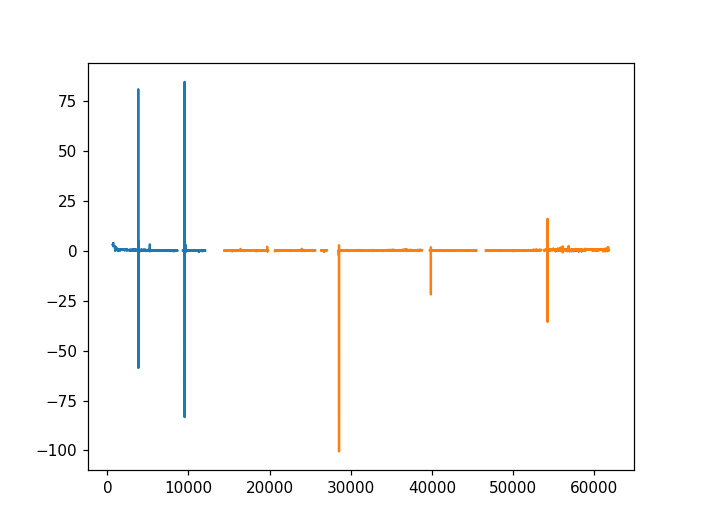

61920
61920


<IPython.core.display.Javascript object>


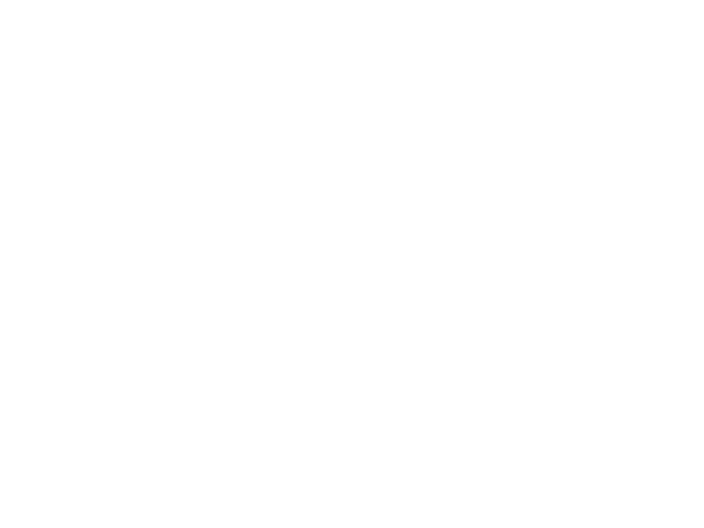

['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_chl', 'acs2_cp', 'acs2_cp_u', 'acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_Asta', 'hplc_But-fuco', 'hplc_Chl_a', 'hplc_Chl_c1', 'hplc_Chl_c1c2', 'hplc_Chl_c2', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Mg_DVP', 'hplc_Neo', 'hplc_PML_only_Anth', 'hplc_PML_only_Chl_b_DVChl_b', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_TChl', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_[ppc]/[tpig]', 'hplc_[psp]/[tpig]', 'hplc_[tacc]/[tchla]', 'hplc_[tchl_a]/[tpig]', 'hplc

In [42]:
#plt.figure()   # cross-over bias for acs chl estimates
#PB = 100*0.5*(acs['acs_chl']-acs['acs2_chl'])/(acs['acs_chl']+acs['acs2_chl']) # percentage bias

PB = 100*(acs['acs_chl']/acs['acs2_chl'] -1)

print(np.sum(~np.isnan(PB))) # ~ 3000 data points
print(np.nanmedian(PB)) # median bias: ~ 2 %


plt.figure()
plt.plot(acs['acs_chl'])
plt.plot(acs['acs2_chl'])

print(len(acs['acs_chl']))
print(len(acs['acs2_chl']))

plt.figure()


print(sorted(list(acs.keys())))


In [43]:
# create acx_chl variable that merges the ac9_chl and acs_chl if available
#acs["acx_chl"] = (acs['time'], np.nanmean(np.asarray([acs['acs2_chl'].values, acs['acs_chl'].values]), axis=0) )
#acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
 #                       "acx_chl_comment":"merged chl a from the two acs systems",
  #                     }

# plot it
#fig,ax = plt.subplots(2,1, figsize=[13,6])
#ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
#ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0.5, ms=3, mfc='none', alpha=0.15)
#ax[0].semilogy(acs['uway_time'], acs.acs2_chl, 'k.', lw=0.5, ms=0.5, mfc='none', alpha=0.15)
#ax[0].set_ylim([0.001, 5])

#plt.figure()
#plt.plot(acs.time)
#plt.plot(acs2.time)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=0.5, ms=8, mfc='none', alpha=0.15)
#plt.xlim(51700,52000)
#ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

In [44]:
acs

<xarray.Dataset>
Dimensions:                               (time: 61920, acs_wv: 176, ac9_wv: 9,
                                           acs2_wv: 176, bb3_wv: 3,
                                           hplc_time: 63)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-09-18 .....
  * acs_wv                                (acs_wv) float64 400.0 402.0 ... 750.0
  * ac9_wv                                (ac9_wv) float64 nan nan ... nan nan
  * acs2_wv                               (acs2_wv) float64 400.0 ... 750.0
  * bb3_wv                                (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                             (hplc_time) datetime64[ns] 2015-09-...
Data variables: (12/122)
    flow                                  (time) float64 ...
    acs_chl                               (time) float64 nan nan nan ... nan nan
    acs_ap                                (time, acs_wv) float64 ...
    acs_ap_u                              (time, acs_wv) float64 ...
    acs_bp                                (time, acs_wv) float64 ...
    acs_bp_u                              (time, acs_wv) float64 ...
    ...                                    ...
    hplc_n_=_other,_s_=_surface;_d_=_dcm  (hplc_time) object 'S' 'S' ... 'S' 'S'
    hplc_unnamed:_15                      (hplc_time) object nan nan ... nan nan
    hplc_Chl_c1c2                         (hplc_time) float64 0.7046 ... 0.01844
    hplc_Tcar                             (hplc_time) float64 3.139 ... 0.1569
    hplc_DP                               (hplc_time) float64 2.705 ... 0.1728
    hplc_file                             <U20 'AMT_25_Pigments.xlsx'

0 5600 5800
1 15500 15650
2 15800 16000
3 16390 16405
4 18600 18800
5 19675 19700
6 20600 20700
7 21000 21180
8 21200 21300
9 24190 24195
10 24250 24255
11 24300 24315
12 25250 25400
13 26650 26720
14 28400 28570
15 29730 29750
16 32600 32700
17 36900 36920
18 38270 38310
19 39870 39880
20 45320 45500
21 53800 53890
22 56100 56160
23 56800 56950
24 58400 58425
25 58575 58580
26 58860 58900
27 2050 2200


<IPython.core.display.Javascript object>


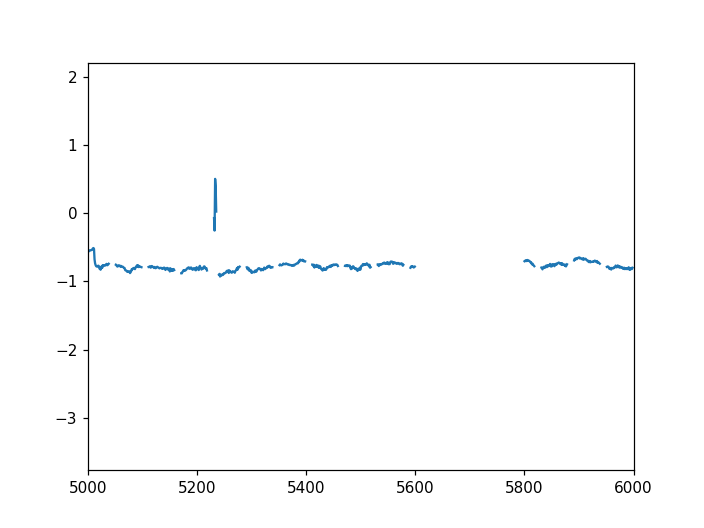

/local1/data/scratch/rsg/tjor/anaconda3/envs/monocle_test_hsp/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


(5000.0, 6000.0)

In [45]:
### manually identify (using plot above) noisy parts of the acs_chl timeseries
i2rm = [ 

    [5600,5800],
    [15500, 15650], # start and end index of noisy period 1
             [15800,16000],  # start and end index of noisy period 2
              [16390,16405],  # start and end index of noisy period 3
              [18600,18800],
              [19675,19700],
              [20600,20700],
              [21000,21180],
              [21200,21300],
              [24190,24195],
              [24250,24255],
              [24300,24315],
              [25250,25400],
              [26650,26720],
              [28400,28570],
              [29730,29750],
              [32600,32700],
              [36900,36920],
              [38270,38310],
              [39870,39880],
              [45320,45500],
              [53800,53890],
              [56100,56160],
              [56800,56950],
              [58400,58425],
              [58575,58580],
              [58860,58900],
              [2050, 2200], # start and end index of noisy period 1
       
       
       ]
    


# set values to nan inside the above intervals
for istart,tmp in enumerate(i2rm):
    print(istart, tmp[0], tmp[1])
    acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    
    acs['acs2_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs2_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    
    
#########
plt.figure()
plt.plot(np.log10(acs['acs_chl']))
plt.xlim(5000,6000)

[  584   585   586 ... 24996 24997 24998]
[    0     1     2 ... 61917 61918 61919]
[    0     1     2 ... 61917 61918 61919]


<IPython.core.display.Javascript object>


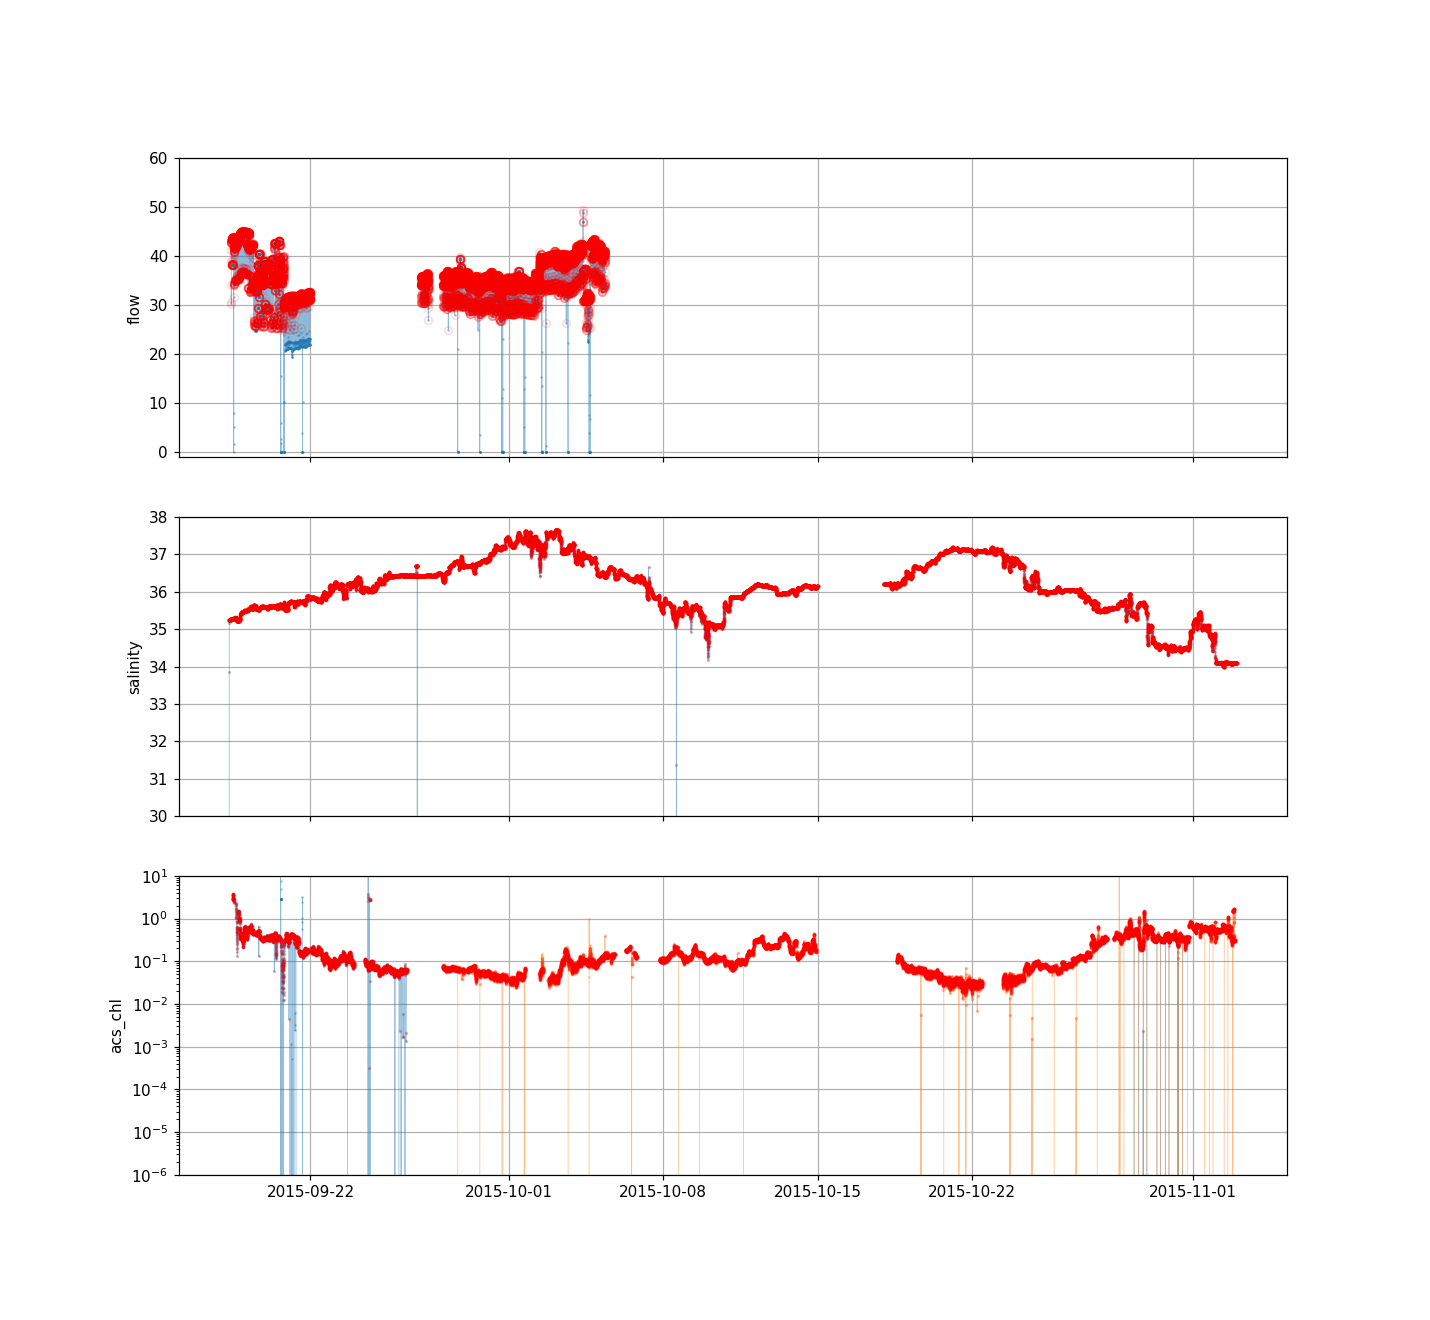

(1e-06, 10)

In [46]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f1 = np.where((acs.uway_sal>MIN_SAL) & (acs.flow>MIN_FLOW_RATE))[0]  
i2f2 = np.where((np.isnan(acs.uway_sal)==True) | (np.isnan(acs.flow)==True))[0]

i2f = np.union1d(i2f1, i2f2)

print(i2f1)
print(i2f2)
print(i2f)

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])


ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')
ax[1].set_ylim([30, 38])

ax[2].semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time, acs.acs2_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].semilogy(acs.time[i2f], acs.acs2_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
plt.ylim([1e-6, 10])

#print(acs.keys())
#print(i2f)
#len(i2f)
#for i in range(len)
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   #acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
#for istart,tmp in enumerate(i2f):
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   # acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


In [47]:

df_hplc_surf.keys()
list(df_hplc['STATION'])
#f_UND = df_hplc_surfloc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]
#df_CTD = f_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")]

[0,
 0,
 0,
 1,
 1,
 2,
 2,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 15,
 17,
 17,
 18,
 18,
 19,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 25,
 25,
 26,
 26,
 27,
 27,
 28,
 28,
 28,
 29,
 29,
 30,
 30,
 31,
 31,
 32,
 32,
 33,
 33,
 34,
 34,
 35,
 35,
 36,
 36,
 37,
 37,
 38,
 38,
 38,
 39,
 39,
 40,
 40,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 45,
 45,
 46,
 46,
 47,
 47,
 48,
 48,
 50,
 50,
 51,
 51,
 52,
 53,
 53,
 53,
 54,
 54,
 55,
 55,
 56,
 56,
 58,
 58,
 59,
 59,
 60,
 60,
 61,
 62,
 62,
 63,
 63,
 64,
 64,
 65]

<IPython.core.display.Javascript object>


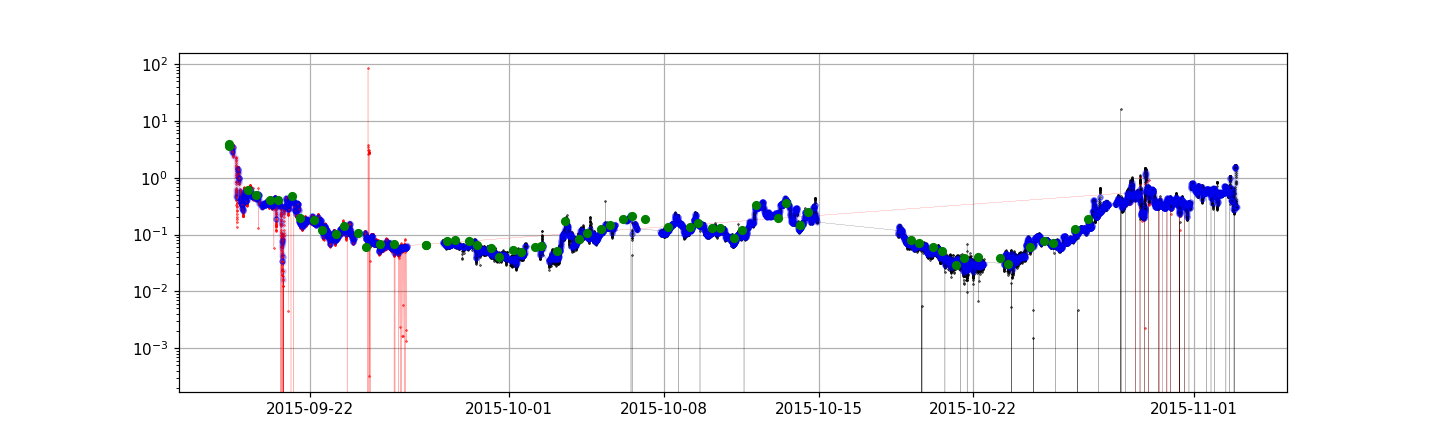

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'uway_field28th', 'uway_field29th', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_volume_filtered_(l)', 'hplc_name_of_water_body', 'hplc_depth', 'hplc_filter_storage_before_analysis', 'hplc_filter_type', 'hplc_filter_diameter', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Alp

<IPython.core.display.Javascript object>


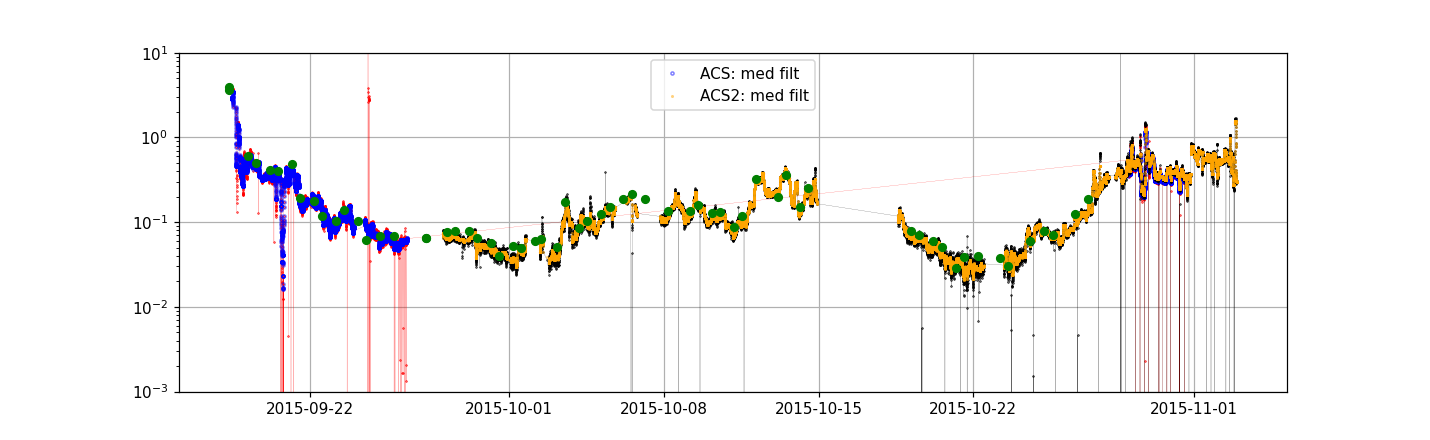

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'uway_field28th', 'uway_field29th', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_volume_filtered_(l)', 'hplc_name_of_water_body', 'hplc_depth', 'hplc_filter_storage_before_analysis', 'hplc_filter_type', 'hplc_filter_diameter', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Alp

/tmp/ipykernel_556969/215321697.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')


In [48]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
ax2.grid('on')
# plt.ylim([1e-6, 10])





print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
#a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
#ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
#ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')



MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS: med filt')
ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')
ax2.grid('on')
plt.legend()
plt.ylim([1e-3, 10])


print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
#a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
#ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
#ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
#########


In [49]:
print(sorted(acs.hplc_Tot_Chl_a)) # identify anomolies with 2 lowest values.

# clip off two anmolies
i2rmv = np.where((acs.hplc_Tot_Chl_a.values < 0.018)) [0]
iy = xr.DataArray(acs.hplc_time[i2rmv], dims=['hplc_time']) 
acs = acs.drop_sel(hplc_time = iy,errors='ignore')

plt.figure()
plt.plot(acs.hplc_time)
#print(i2kp)

[<xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.02915422)
Coordinates:
    hplc_time  datetime64[ns] 2015-10-21T04:57:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.03079726)
Coordinates:
    hplc_time  datetime64[ns] 2015-10-23T13:58:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.03800873)
Coordinates:
    hplc_time  datetime64[ns] 2015-10-23T04:56:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.03932662)
Coordinates:
    hplc_time  datetime64[ns] 2015-10-21T13:58:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.03963768)
Coordinates:
    hplc_time  datetime64[ns] 2015-10-22T04:55:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.04020587)
Coordinates:
    hplc_time  datetime64[ns] 2015-09-30T12:59:00
Attributes:
    units:    mg/m3, <xarray.DataArray 'hplc_Tot_Chl_a' ()>
array(0.04953612)
Coordinates:
    hplc_ti

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

<IPython.core.display.Javascript object>


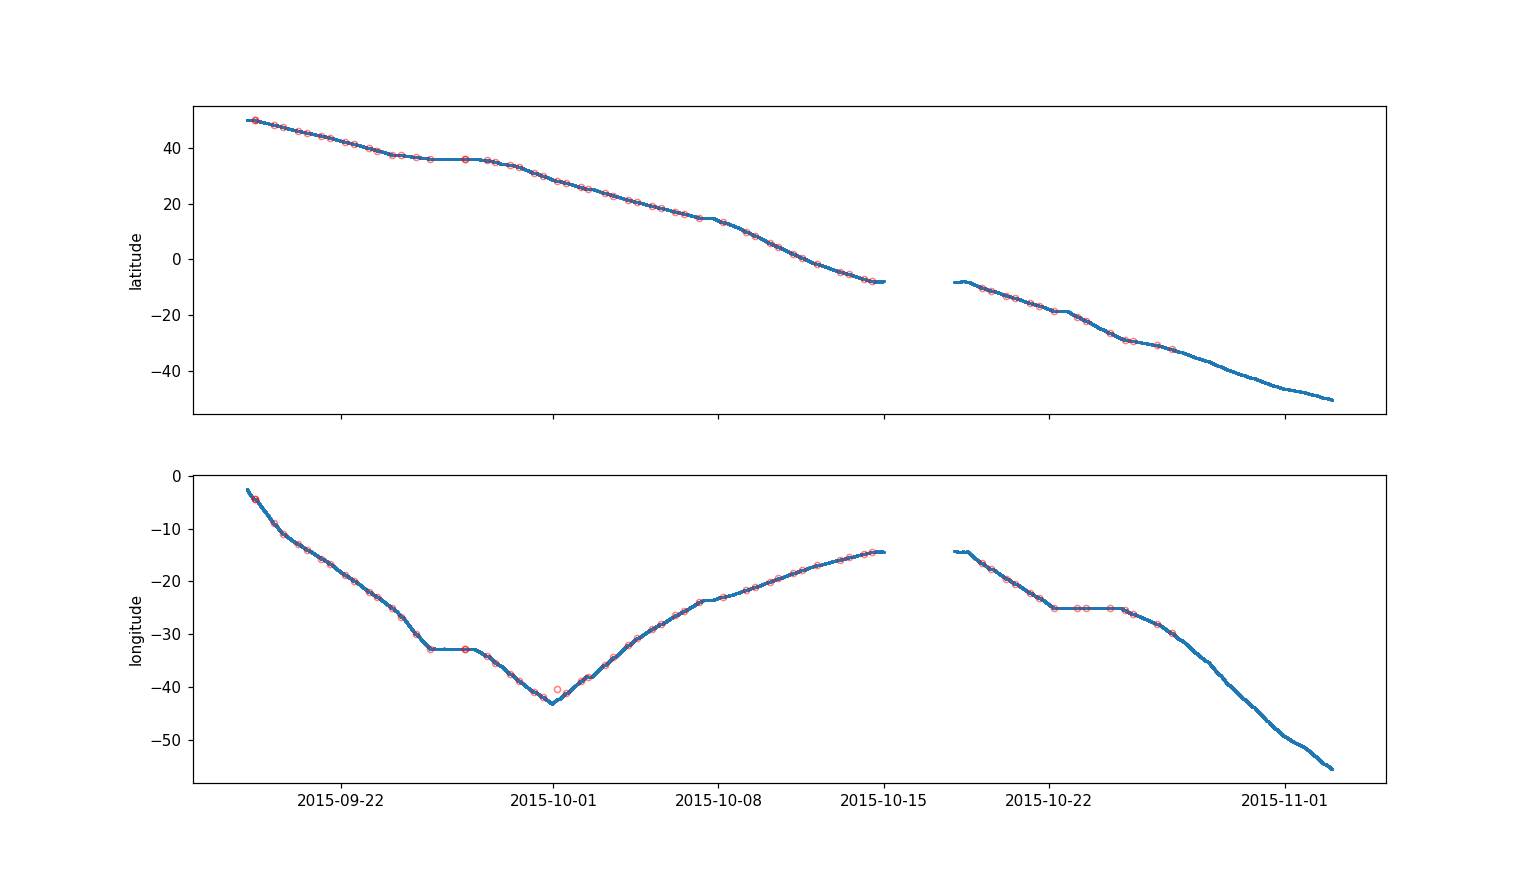

Text(0, 0.5, 'longitude')

In [50]:
# compare lat and lon of hplc and acs datasets
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[0].set_ylabel("latitude")
ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[1].set_ylabel("longitude")

<IPython.core.display.Javascript object>


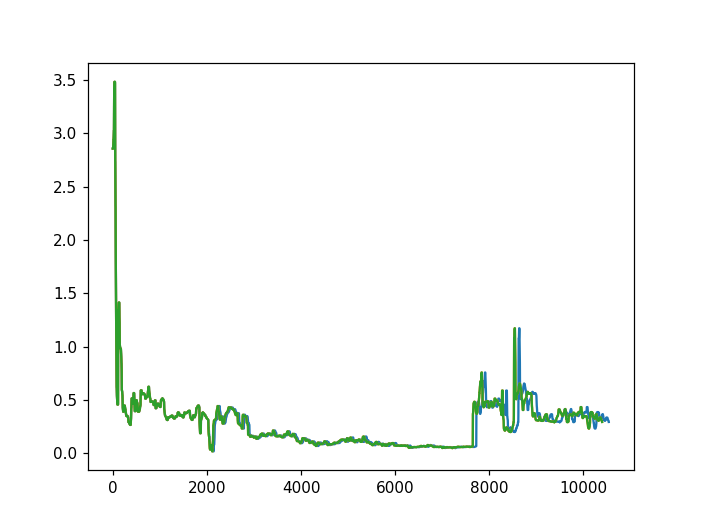

In [51]:
# df_CTD.keys()
# print(df_hplc_acs)
#df_hplc_combined['Tot_Chl_a'][0:14]= df_hplc_acs['Tot_Chl_a'][0:14]

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs_filtered_x['acs_chl'].values)

#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)
plt.plot(acs_filtered_xy['acs_chl'].values)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)
plt.plot(acs_filtered_xyz['acs_chl'].values)




<IPython.core.display.Javascript object>


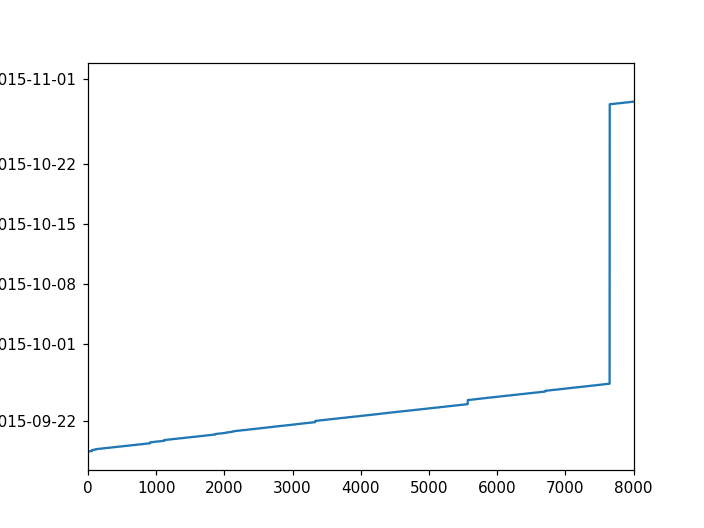

In [52]:
# remmove duplicate values from acs dataframe
plt.figure()
plt.plot(acs_filtered_xyz['time'])
plt.xlim(0,8000)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.arange(0,7648)
iz = xr.DataArray(acs_filtered_xyz.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xyz.sel(time = iz)


<IPython.core.display.Javascript object>


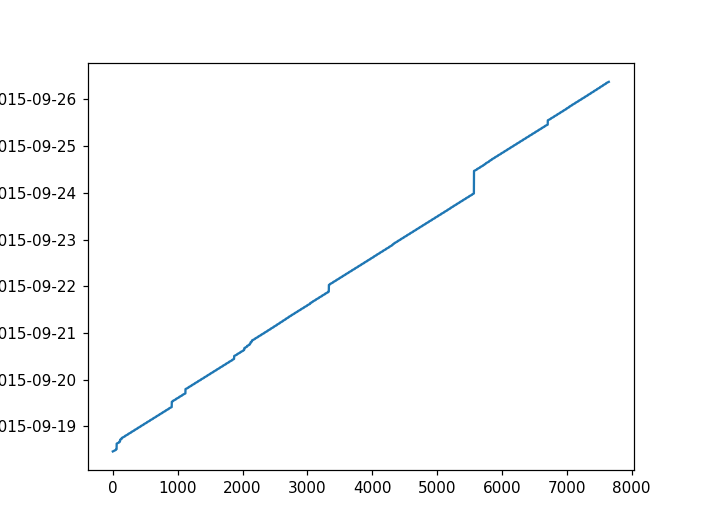

In [53]:
plt.figure()
plt.plot(acs_filtered_xyz['time'])

<IPython.core.display.Javascript object>


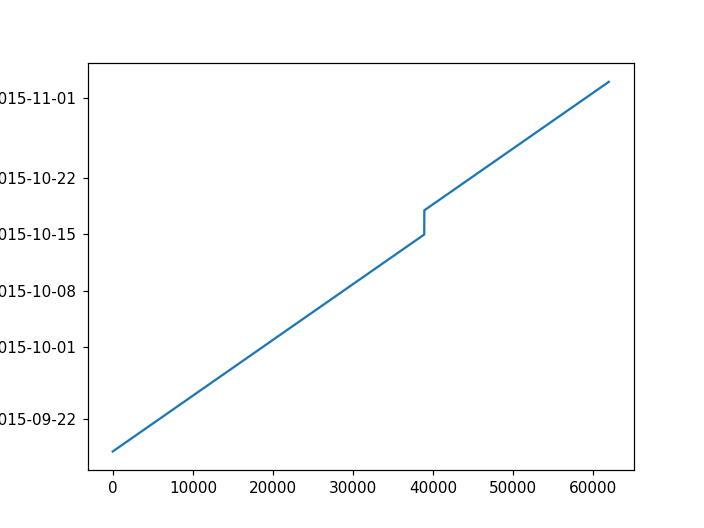

In [54]:
plt.figure()
plt.plot(acs['time'])


<IPython.core.display.Javascript object>


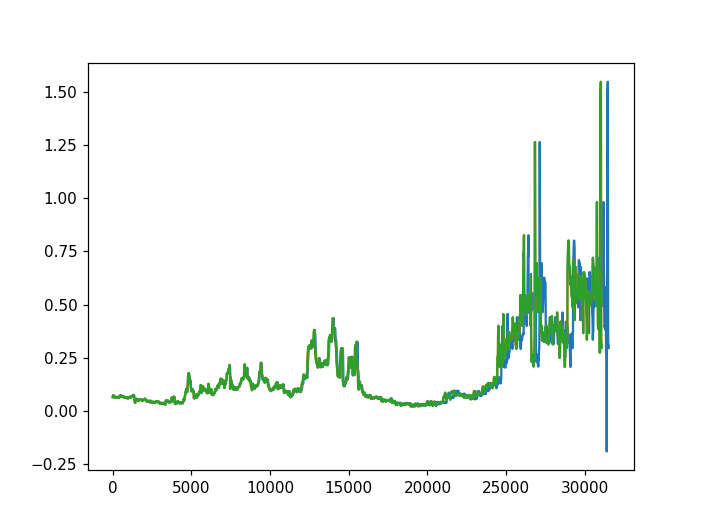

[]

In [55]:
# repeat for ACS 2

#plt.plot(np.log10(acs['acs2_chl_debiased'].values[i2f][innan2]))
ix = xr.DataArray(acs.time[i2f][innan2], dims=['time']) 
acs2_filtered_x = acs.sel(time = ix)
acs2_filtered_x['acs2_chl'].values = sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
plt.figure()
plt.plot(acs2_filtered_x['acs2_chl'].values)

# step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs2_filtered_x.acs2_ap[:,10] > 0))[0]
iy = xr.DataArray(acs2_filtered_x.time[i2kp], dims=['time']) 
acs2_filtered_xy = acs2_filtered_x.sel(time = iy)
plt.plot(acs2_filtered_xy['acs2_chl'].values)


# step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs2_filtered_xy.acs2_chl[:] > 0)) [0]
iz = xr.DataArray(acs2_filtered_xy.time[i2kp], dims=['time']) 
acs2_filtered_xyz = acs2_filtered_xy.sel(time = iz)
plt.plot(acs2_filtered_xyz['acs2_chl'].values)

plt.plot()

In [56]:
key_string = acs_filtered_xyz.keys()
hplc_keys = [s for s in key_string if "hplc" in s]
other_keys = [s for s in key_string if "hplc" not in s]

acs_matches = xr.concat([acs_filtered_xyz, acs2_filtered_xyz],data_vars=other_keys,dim='time') # combines the 2 filtered x-rays back into net cdf (hplc keys are common)



In [57]:
print(df_hplc_surf)

                            Label Sample Collector Cruise Name  \
time                                                             
2015-09-18 07:55:00  AMT25-001-2A       Bob Brewin       AMT25   
2015-09-18 07:55:00  AMT25-001-2B       Bob Brewin       AMT25   
2015-09-19 04:09:00  AMT25-002-2A       Bob Brewin       AMT25   
2015-09-19 13:00:00  AMT25-003-2A       Bob Brewin       AMT25   
2015-09-20 04:05:00  AMT25-004-2A       Bob Brewin       AMT25   
...                           ...              ...         ...   
2015-10-24 13:56:00  AMT25-061-2A       Bob Brewin       AMT25   
2015-10-25 05:12:00  AMT25-062-2A       Bob Brewin       AMT25   
2015-10-25 14:15:00  AMT25-063-2A       Bob Brewin       AMT25   
2015-10-26 14:10:00  AMT25-064-2A       Bob Brewin       AMT25   
2015-10-27 05:07:00  AMT25-065-2A       Bob Brewin       AMT25   

                     Volume filtered (L) Name of Water Body  depth  \
time                                                                 
2

In [58]:

# create pandas series with HPLC Tot_Chl_a data
ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

# averages duplicate values
ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
df_acs = pd.Series(acs_matches.acs_chl, index = acs_matches.time.values)
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})
df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(ds_hplc_surf.index,method='nearest',tolerance='30min')
#df_hplc_acs[14:] = np.nan


# create pandas series with medfilt ACS data: ACS2
df_acs2 = pd.Series(acs_matches.acs2_chl, index = acs_matches.time.values)
df_hplc_acs2 = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs2_chl': df_acs2})
df_hplc_acs2 = df_hplc_acs2.interpolate('index',limit=1).reindex(ds_hplc_surf.index,method='nearest',tolerance='30min')


a = np.array(df_hplc_acs['Tot_Chl_a'])[0:15]
b = np.array(df_hplc_acs2['Tot_Chl_a'])[15:]
Tot_chl_combined = np.concatenate([a,b])

c = np.array(df_hplc_acs['acs_chl'])[0:15]
d = np.array(df_hplc_acs2['acs2_chl'])[15:]
acs_combined = np.concatenate([c,d])




len(c)
len(d)
len(acs_combined)

61

In [59]:
# # merge HPCL and ACS data
# # see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate

# # create pandas series with HPLC Tot_Chl_a data
#ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)
#print(df_hplc_surf)

# # averages duplicate values
#ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

# # create pandas series with medfilt ACS data: ACS
#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
#df_hplc_acs=df_hplc_acs.iloc[1:14,:] # HPLC indicies where ACS1 is present (need to clip due to interpolation)


# # create pandas series with medfilt ACS data: ACS2
#df_acs2 = pd.Series(sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31), index = acs.time.values[i2f][innan2])
#df_hplc_acs2 = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs2_chl': df_acs2})
#df_hplc_acs2 = df_hplc_acs2.interpolate('index').reindex(ds_hplc_surf.index)
#df_hplc_acs2['Tot_Chl_a'][0:15]=np.nan


#a = np.array(df_hplc_acs['Tot_Chl_a'])[0:14]
#b = np.array(df_hplc_acs2['Tot_Chl_a'])[15:]
#Tot_chl_combined = np.concatenate([a,b])

#c = np.array(df_hplc_acs['acs_chl'])[0:14]
#d = np.array(df_hplc_acs2['acs2_chl'])[15:]
#acs_combined = np.concatenate([c,d])


In [60]:
#df_CTD.keys()

<IPython.core.display.Javascript object>


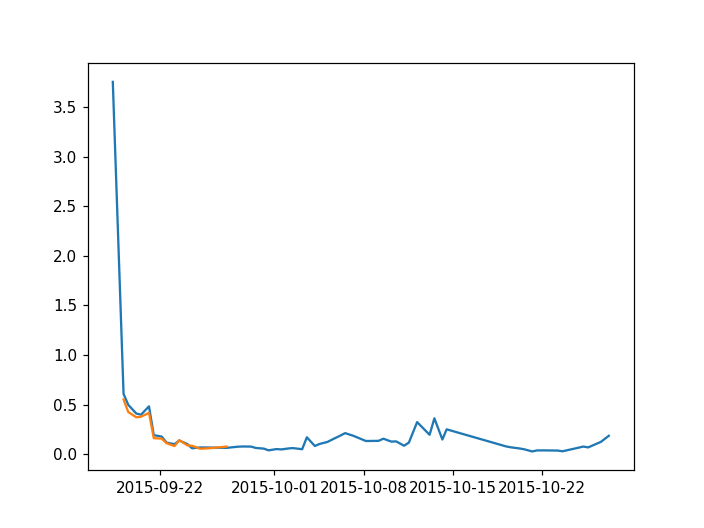

In [61]:
plt.figure()
#plt.plot(df_hplc_acs)

plt.plot(df_hplc_acs)

In [62]:
#df_hplc_surf_new = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
#df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    


In [63]:
# compute residuals and stats - LOG

#rres = np.log10(df_hplc_acs.acs_chl.values) / np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

#delta = np.nanmedian(rres)

#sigma = prcrng(rres)

#N = len(rres)


#print(delta, sigma, N)


# compute residuals and stats for ACS2

#rres2 = np.log10(df_hplc_acs2.acs2_chl.values)/np.log10(df_hplc_acs2.Tot_Chl_a.values) - 1

#delta2 = np.nanmedian(rres2)

#sigma2 = prcrng(rres2)

#N2 = sum(~np.isnan(rres2))

#print(delta2, sigma2, N2)



rres3 = np.log10(acs_combined)/np.log10(Tot_chl_combined) - 1

delta3 = np.nanmedian(rres3)

sigma3 = prcrng(rres3)

N3 = len(~np.isnan(rres3))

print(delta3, sigma3, N3)


#0.07399467389400294 0.08571524651824988 13
#0.050213942799685274 0.048064638021620275 47
#0.05905804626541811 0.05352515125099466 60


0.06015199663689619 0.051992180522370854 61


In [64]:
# compute residuals and stats - LINEAR
#rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
#delta = np.nanmedian(rres)
#sigma = prcrng(rres)
#sigma = np.nanstd(rres)
#N = len(rres)

#print(delta, sigma, N)

# compute residuals and stats for ACS2
#rres2 = df_hplc_acs2.acs2_chl.values/df_hplc_acs2.Tot_Chl_a.values - 1
#delta2 = np.nanmedian(rres2)
#sigma2 = prcrng(rres2)
#sigma2 = np.nanstd(rres2)
#N2 = sum(~np.isnan(rres2))
#print(delta2, sigma2, N2)


# compute residuals and stats for ACSc combined

rres3 = acs_combined/Tot_chl_combined - 1
delta3 = np.nanmedian(rres3)
sigma3 = prcrng(rres3)
N3 = len(~np.isnan(rres3))

print(delta3, sigma3, N3)

-0.11834252690724456 0.0976939756495996 61


In [65]:
#plt.figure()
#plt.plot(df_hplc_acs.Tot_Chl_a.values,label='HPLC',color='green')
#plt.plot(df_hplc_acs.acs_chl.values,label='ACS')
#plt.plot(df_hplc_acs2.Tot_Chl_a.values,color='green')
#plt.plot(df_hplc_acs2.acs2_chl.values,label='ACS2')
#plt.ylabel('Tot Chl-a concentration (mg/m^3)')
#plt.xlabel('Sample index')
#plt.legend()

#print(df_hplc_acs.Tot_Chl_a.values)
#print(df_hplc_acs.acs_chl.values)
#print(df_hplc_acs2.acs2_chl.values)

# compute residuals and stats (lin and log space)
#rres = acs_combined/Tot_chl_combined - 1

#rres_log = np.log10(acs_combined) / np.log10(Tot_chl_combined) - 1
#
#delta = np.nanmedian(rres)
#delta_log = np.nanmedian(rres_log)
#sigma = prcrng(rres)
#sigma_log = prcrng(rres_log)
#N = np.sum(~np.isnan(rres))

#print(delta, sigma, N)

#print(delta_log, sigma_log, N)

<IPython.core.display.Javascript object>


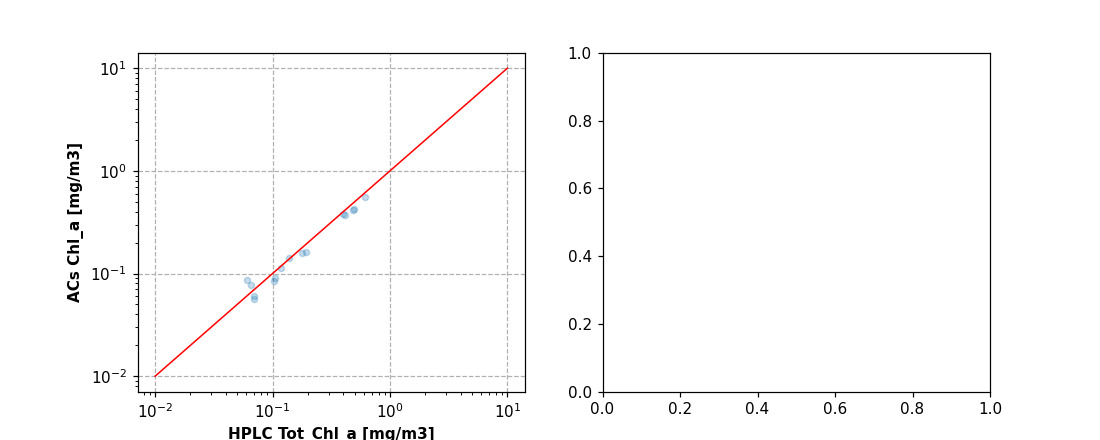

NameError: name 'rres' is not defined

In [66]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


print(df_hplc_acs.Tot_Chl_a.values)

<IPython.core.display.Javascript object>


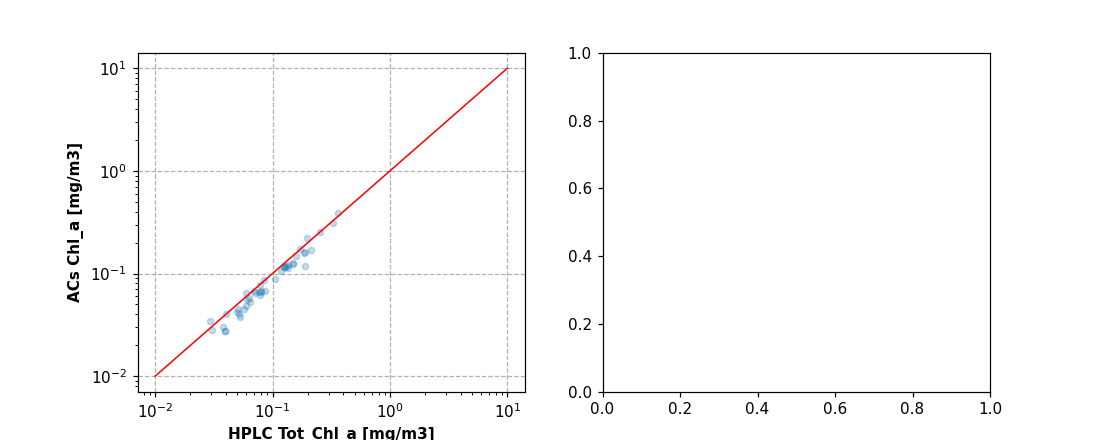

NameError: name 'rres2' is not defined

In [67]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs2.Tot_Chl_a.values, df_hplc_acs2.acs2_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs2.Tot_Chl_a.values, rres2, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta2:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma2: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N2: 0}', fontweight='bold')


print(df_hplc_acs.Tot_Chl_a.values)

<IPython.core.display.Javascript object>


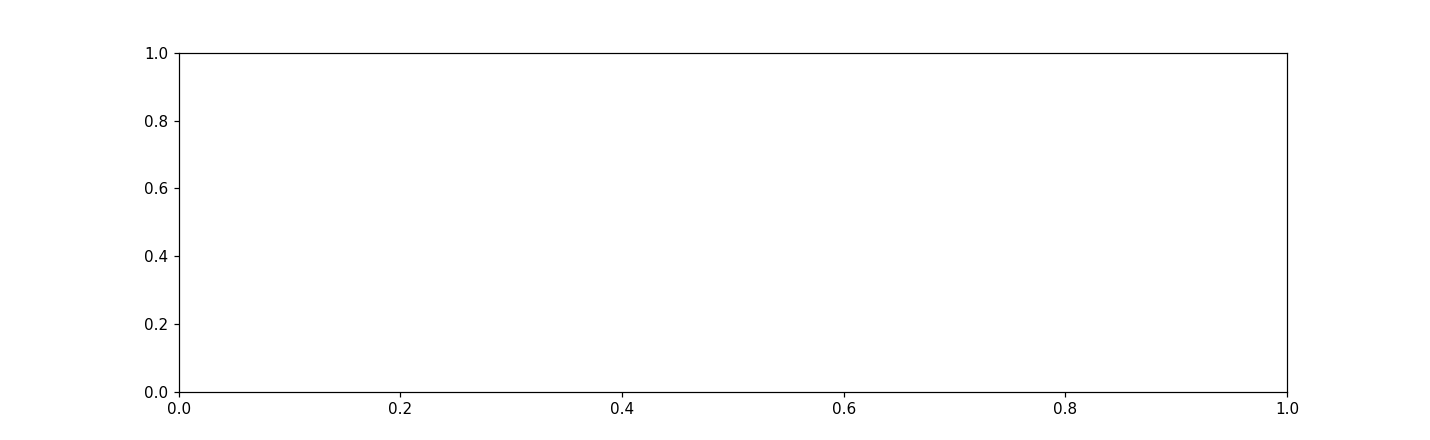

NameError: name 'rres' is not defined

In [68]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [69]:
ilrg_rres = np.where(abs(rres)>0.5)[0]
print(rres[ilrg_rres])
df_hplc_surf_new.iloc[ilrg_rres]

NameError: name 'rres' is not defined

<IPython.core.display.Javascript object>


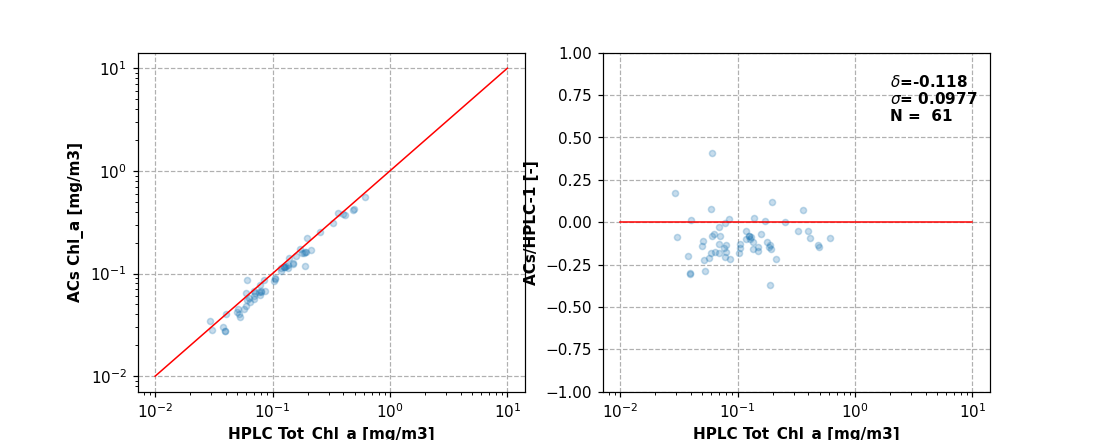

Text(2, 0.6, 'N =  61')

In [70]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(Tot_chl_combined, acs_combined, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(Tot_chl_combined, rres3, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta3:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma3: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N3: 0}', fontweight='bold')


In [71]:
df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

NameError: name 'df_hplc_surf_new' is not defined

In [72]:
df_hplc_surf_new.iloc[ilrg_rres].keys()

NameError: name 'df_hplc_surf_new' is not defined

In [73]:
# find dates of large rres
r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][iss]]

time
2015-09-24 13:00:00    0.406573
dtype: float64


In [74]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [75]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [76]:
# fit data to power law -- not useD?
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

print(acs_combined)

popt, pcov = curve_fit(func, 0.014*acs_combined[~np.isnan(acs_combined)], Tot_chl_combined[~np.isnan(acs_combined)])

perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 



print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )




[       nan 0.55336031 0.42625768 0.37322744 0.3790719  0.41827192
 0.16294601 0.15813302 0.11225962 0.08366533 0.14298975 0.09111052
 0.08582274 0.05672383 0.0600897         nan 0.06547045 0.06821074
 0.06202055 0.05289034 0.04556227 0.04069325 0.03758287 0.04253337
 0.05549489 0.05823363 0.03995628 0.17273809 0.08574411 0.08836091
 0.11503128 0.12459729 0.16321067 0.16765133 0.11805326 0.1133602
 0.11985605 0.14678374 0.11568739 0.11936737 0.06766447 0.10640053
 0.30777594 0.2208294  0.38822742 0.12738316 0.25208277 0.06539618
 0.06486054 0.04863391 0.04522455 0.03419639 0.02752063 0.02758326
 0.03038837 0.02804333 0.06415682 0.07811241 0.06773145 0.11482345
 0.1594491 ]
chl_HPLC = a * chl_ACS^b 
a = 70.9 +/- 7.5
b = 0.983 +/- 0.019



A = 60.25595860743578 +/- 2.317554712310252
B = 0.956 +/- 0.044
0.971


<IPython.core.display.Javascript object>


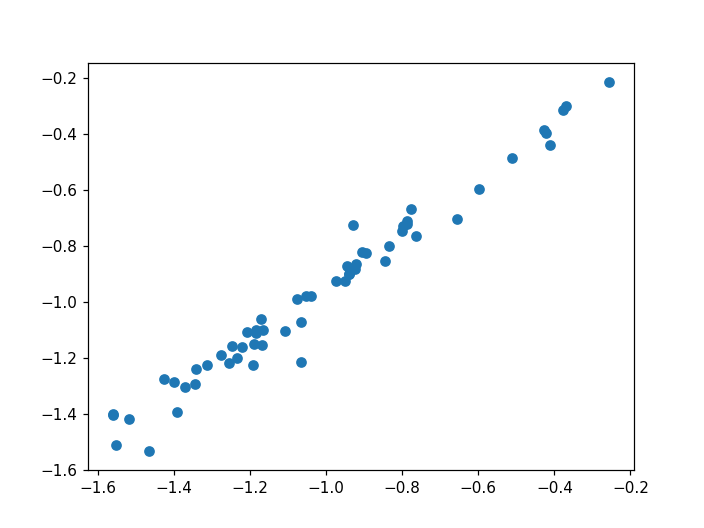

In [77]:
# as previous but apply log transform prior to fitting
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*acs_combined[~np.isnan(acs_combined)]), np.log10(Tot_chl_combined[~np.isnan(acs_combined)]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print()

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))

print(r_sq)

plt.figure()
plt.scatter(np.log10(acs_combined[~np.isnan(acs_combined)]), np.log10(Tot_chl_combined[~np.isnan(acs_combined)]))

In [78]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')

print(len(df_hplc_acs.acs_chl.values))
print(len(df_hplc_acs2.acs2_chl.values))
print(len(df_hplc_acs2.Tot_Chl_a.values))
print(len(df_hplc_acs.index))


61
61
61
61


In [79]:
# add attributes to acs_chl_debiased
#acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
#acs.acs_chl_debiased.attrs["delta"] = delta3 # delta 3 and sigma 3 are for combined debiasing (2 AC-S)
#acs.acs_chl_debiased.attrs["sigma"] = sigma3
#acs.acs_chl_debiased.attrs["units"] = "mg/m3"
#acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
#acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
#acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
#acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
#acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
#acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
#acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


#acs.acs2_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
#acs.acs2_chl_debiased.attrs["delta"] = delta3
#acs.acs2_chl_debiased.attrs["sigma"] = sigma3
#acs.acs2_chl_debiased.attrs["units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
#acs.acs2_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs2.Tot_Chl_a.values
#acs.acs2_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["acs_chl"] = df_hplc_acs2.acs2_chl.values
#acs.acs2_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
#acs.acs2_chl_debiased.attrs["match_up_dates"] = df_hplc_acs2.index.format()



In [80]:

len(Tot_chl_combined)



61

In [81]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta3) # delta 3 is combined delta
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_lon[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])


# de-bias ACS-2 
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0]
acs['acs2_chl_debiased'] = acs.acs2_chl*(1-delta3)  # delta 3 is combined delta
acs2_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan2],
                               'lon [degE]': acs.uway_lon[i2f][innan2],
                               'acs2_chl_debiased [mg_m3]': acs.acs2_chl_debiased[i2f][innan2]
                              }  )
                    #  index = acs.time.values[i2f][innan])
# acs_out.index.rename('date_time [UTC]', inplace = True)
acs_out.index.rename('date_time [UTC]', inplace = True)
acs2_out.index.rename('date_time [UTC]', inplace = True)

In [82]:
len

<function len(obj, /)>

In [103]:
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta3 # delta 3 and sigma 3 are for combined debiasing (2 AC-S systems)
acs.acs_chl_debiased.attrs["sigma"] = sigma3
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = Tot_chl_combined
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] =  acs_combined
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


acs.acs2_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs2_chl_debiased.attrs["delta"] = delta3
acs.acs2_chl_debiased.attrs["sigma"] = sigma3
acs.acs2_chl_debiased.attrs["units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs2_chl_debiased.attrs["HPLC_Tot_chla"] = Tot_chl_combined
acs.acs2_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["acs_chl"] =  acs_combined
acs.acs2_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs2_chl_debiased.attrs["match_up_dates"] = df_hplc_acs2.index.format()


In [104]:
acs['acs_chl_debiased']

<xarray.DataArray 'acs_chl_debiased' (time: 61920)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2015-09-18 ... 2015-11-02T23:59:00.000003584
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                -0.11834252690724456
    sigma:                0.0976939756495996
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [3.75346916 0.60903397 0.49886921 0.41114999 0.3994...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [       nan 0.55336031 0.42625768 0.37322744 0.3790...
    acs_chl_units:        mg/m3
    processed_on:         2024-02-28 14:32:19.503009
    match_up_dates:       ['2015-09-18 07:55:00', '2015-09-19 04:09:00', '201...

In [132]:
acs['acs_chl_nomedfilt'] = acs.acs_chl[i2f][innan] # save non-filtered data as separte fie;ds
acs['acs_chl_debiased_nomedfilt'] = acs.acs_chl_debiased[i2f][innan]
acs['acs2_chl_nomedfilt'] = acs.acs2_chl[i2f][innan2] # save non-filtered data as separte fie;ds
acs['acs2_chl_debiased_nomedfilt'] = acs.acs2_chl_debiased[i2f][innan2]


<IPython.core.display.Javascript object>


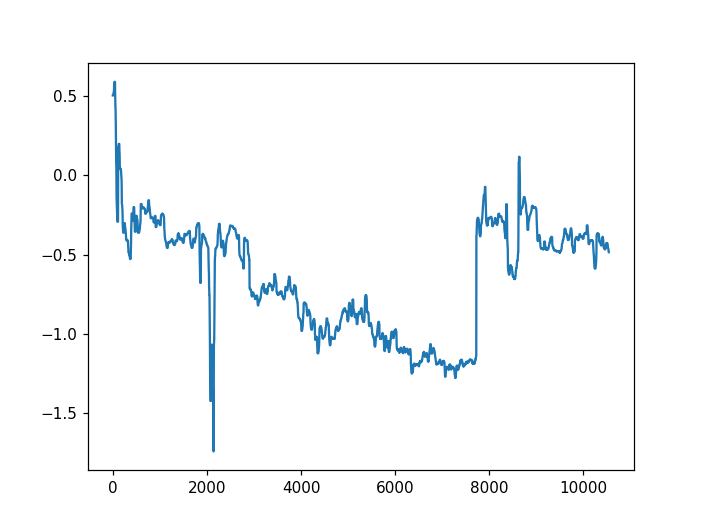

<IPython.core.display.Javascript object>


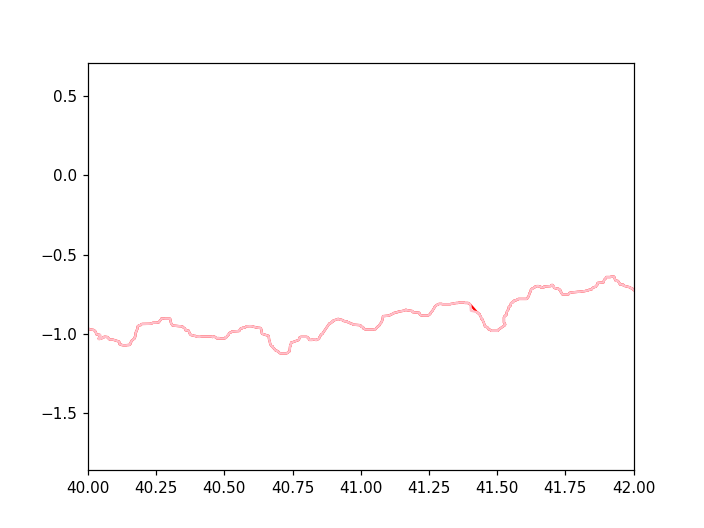

(40.0, 42.0)

In [133]:

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
#plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
#acs_filtered_x['acs_chl_nomedfilt'] = acs.acs_chl[i2f][innan] # save non-filtered data
#acs_filtered_x['acs_chl_debiased_nomedfilt'] = acs.acs_chl_debiased[i2f][innan]
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs_filtered_x['acs_chl_debiased'].values = sg.medfilt(acs.acs_chl_debiased[i2f][innan], kernel_size=31)
plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))

#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)

plt.figure()
plt.plot(acs_filtered_xyz['uway_lat'],np.log10(acs_filtered_xyz['acs_chl_debiased'].values),color='red')
plt.plot(acs_filtered_x['uway_lat'],np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')
plt.xlim(40,42)


<IPython.core.display.Javascript object>


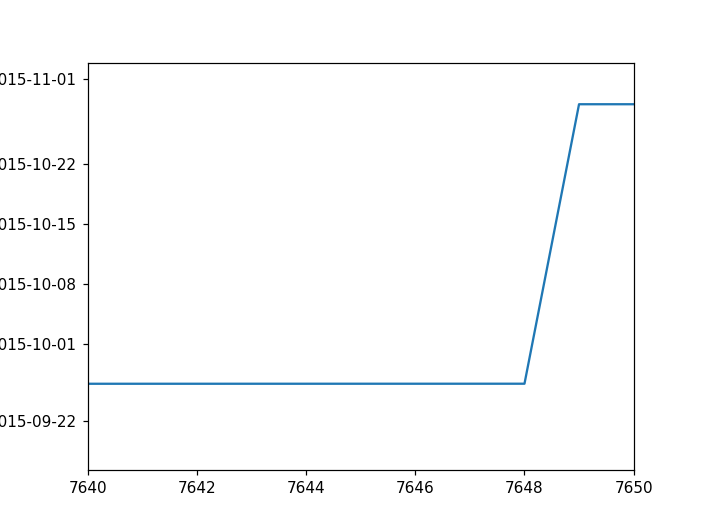

In [134]:
# remmove duplicate values from acs dataframe
plt.figure()
plt.plot(acs_filtered_xyz['time'])
plt.xlim(7640,7650)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.arange(0,7648)
iz = xr.DataArray(acs_filtered_xyz.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xyz.sel(time = iz)

<IPython.core.display.Javascript object>


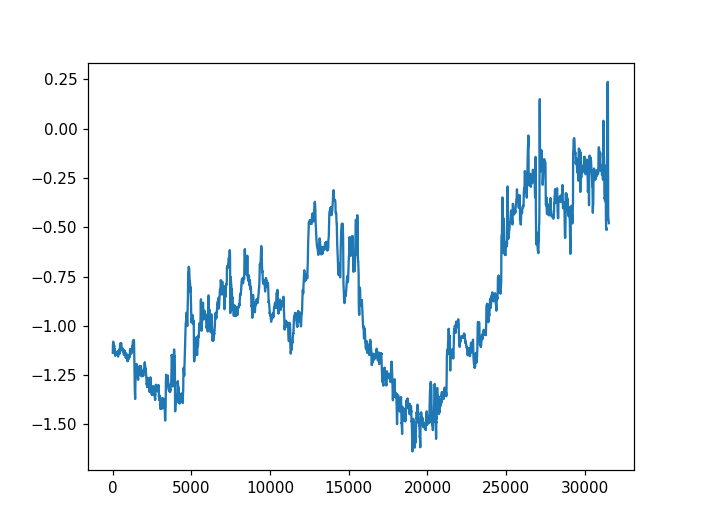

/tmp/ipykernel_556969/1033730997.py:8: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs2_filtered_x['acs2_chl_debiased'].values))


<IPython.core.display.Javascript object>


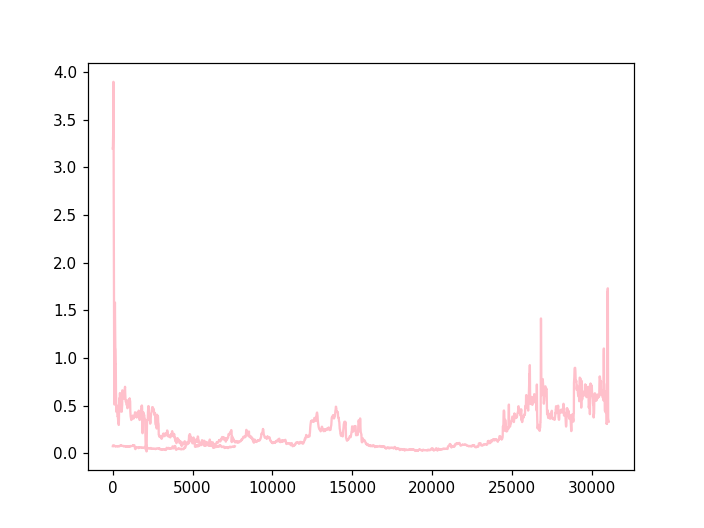

In [135]:
# repeat for ACS 2
plt.figure()
#plt.plot(np.log10(acs['acs2_chl_debiased'].values[i2f][innan2]))
ix = xr.DataArray(acs.time[i2f][innan2], dims=['time']) 
acs2_filtered_x = acs.sel(time = ix)
acs2_filtered_x['acs2_chl'].values = sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs2_filtered_x['acs2_chl_debiased'].values = sg.medfilt(acs.acs2_chl_debiased[i2f][innan2], kernel_size=31)
plt.plot(np.log10(acs2_filtered_x['acs2_chl_debiased'].values))

# step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs2_filtered_x.acs2_ap[:,10] > 0))[0]
iy = xr.DataArray(acs2_filtered_x.time[i2kp], dims=['time']) 
acs2_filtered_xy = acs2_filtered_x.sel(time = iy)

# step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs2_filtered_xy.acs2_chl[:] > 0)) [0]
iz = xr.DataArray(acs2_filtered_xy.time[i2kp], dims=['time']) 
acs2_filtered_xyz = acs2_filtered_xy.sel(time = iz)

plt.figure()
#plt.plot(acs2_filtered_xyz['uway_lat'], np.log10(acs2_filtered_xyz['acs2_chl_debiased'].values),color='red')
plt.plot(acs2_filtered_xyz['acs2_chl_debiased'].values, color='pink')
plt.plot(acs_filtered_xyz['acs_chl_debiased'].values, color='pink')


In [136]:
acs_filtered2 

<xarray.Dataset>
Dimensions:                               (time: 38730, acs_wv: 176,
                                           acs2_wv: 176, bb3_wv: 3,
                                           hplc_time: 63)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-09-18T11...
  * acs_wv                                (acs_wv) float64 400.0 402.0 ... 750.0
  * acs2_wv                               (acs2_wv) float64 400.0 ... 750.0
  * bb3_wv                                (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                             (hplc_time) datetime64[ns] 2015-09-...
Data variables: (12/112)
    flow                                  (time) float64 43.69 43.81 ... nan nan
    acs_chl                               (time) float64 2.858 2.858 ... nan nan
    acs_ap                                (time, acs_wv) float64 0.1349 ... nan
    acs_ap_u                              (time, acs_wv) float64 0.005874 ......
    acs_bp                                (time, acs_wv) float64 0.7259 ... nan
    acs_bp_u                              (time, acs_wv) float64 0.007568 ......
    ...                                    ...
    hplc_DP                               (hplc_time) float64 2.705 ... 0.1728
    hplc_file                             <U20 'AMT_25_Pigments.xlsx'
    acs_chl_debiased                      (time) float64 3.196 3.196 ... nan nan
    acs2_chl_debiased                     (time) float64 nan nan ... 0.3315
    acs_chl_nomedfilt                     (time) float64 nan nan ... 0.3018
    acs_chl_debiased_nomedfilt            (time) float64 nan nan ... 0.3375

In [137]:
#len(acs.acs_chl_debiased.HPLC_Tot_chla)
len(acs.acs_chl_debiased.HPLC_Tot_chla)

61

<IPython.core.display.Javascript object>


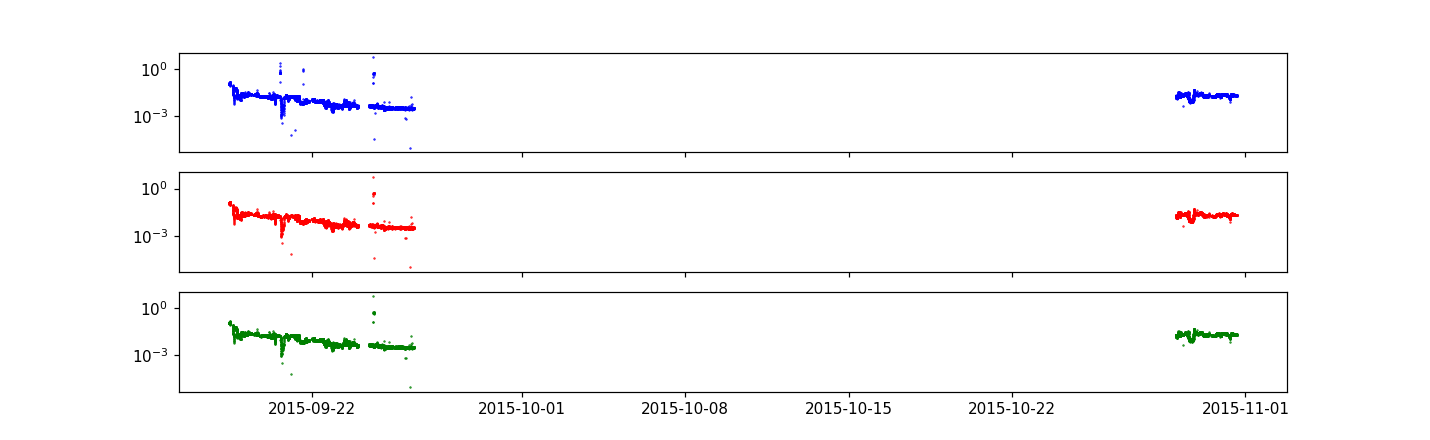

In [138]:
# plot to check                   
#iwv = np.where(acs_filtered.acs_wv==490)[0]
#fig, [ax, ax2] = plt.subplots(2,1, figsize=(13, 4), sharex=True)

#ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
# ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')

#ax2.grid('on')

fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

iwv = np.where(acs_filtered_x.acs_wv==490)[0]
ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')


In [139]:
print(acs_filtered_xyz.keys())
print(acs2_filtered_xyz.keys())


KeysView(<xarray.Dataset>
Dimensions:                               (time: 7648, acs_wv: 176, ac9_wv: 9,
                                           acs2_wv: 176, bb3_wv: 3,
                                           hplc_time: 63)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-09-18T11...
  * acs_wv                                (acs_wv) float64 400.0 402.0 ... 750.0
  * ac9_wv                                (ac9_wv) float64 nan nan ... nan nan
  * acs2_wv                               (acs2_wv) float64 400.0 ... 750.0
  * bb3_wv                                (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                             (hplc_time) datetime64[ns] 2015-09-...
Data variables: (12/128)
    flow                                  (time) float64 43.69 43.81 ... nan nan
    acs_chl                               (time) float64 2.858 2.858 ... 0.06517
    acs_ap                                (time, acs_wv) float64 0.1349 ... -...
    acs_ap_u 

In [140]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
#acs_filtered2 = acs_filtered_xyz 

#print(len(acs_filtered_xyz['time']))
#print(len(acs2_filtered_xyz['time']))

key_string = acs_filtered_xyz.keys()
hplc_keys = [s for s in key_string if "hplc" in s]
other_keys = [s for s in key_string if "hplc" not in s]

#data_vars='all'

acs_filtered2  = xr.concat([acs_filtered_xyz, acs2_filtered_xyz],data_vars=other_keys,dim='time') # combines the 2 filtered x-rays back into net cdf (hplc keys are common)



In [141]:
acs_filtered2['hplc_depth']

<xarray.DataArray 'hplc_depth' (hplc_time: 63)>
array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
Coordinates:
  * hplc_time  (hplc_time) datetime64[ns] 2015-09-18T07:55:00 ... 2015-10-27T...

In [142]:
#test for similar keys between AMT28 and AMT29 (baseline)

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_25 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_25).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_25 =  set(keys_25) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(sorted(common_keys))

print('/n extra keys in amt25')
print(sorted(extra_keys_25))

# manual clean up of AMT 27 keys
# acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
# acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
# acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

# manual clean up of AMT 26 keys
acs_filtered2 = acs_filtered2.drop('ac9_N')
acs_filtered2 = acs_filtered2.drop('ac9_ap')
acs_filtered2 = acs_filtered2.drop('ac9_ap_u')
acs_filtered2 = acs_filtered2.drop('ac9_bp')
acs_filtered2 = acs_filtered2.drop('ac9_bp_u')
acs_filtered2 = acs_filtered2.drop('ac9_chl')
acs_filtered2 = acs_filtered2.drop('ac9_cp')
acs_filtered2 = acs_filtered2.drop('ac9_cp_u')
acs_filtered2 = acs_filtered2.drop('ac9_wv')


# clean-up extra pigments
acs_filtered2 = acs_filtered2.drop('hplc_[ppc]/[tpig]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[psp]/[tpig]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[tacc]/[tchla]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[tchl_a]/[tpig]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc__[chl_c2mgdg-1]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc__[chl_c2mgdg-2]') # redundant


#print('/n extra keys in amt29')
#print(sorted(extra_keys_29))

#print('/n extra keys in amt26')
#print(sorted(extra_keys_26))
#sorted(acs_filtered2.keys())

common keys
['acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_But-fuco', 'hplc_Chl_c1c2', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Neo', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_bottle', 'hplc_depth', 'hplc_filter_diameter', 'hplc_filter_type', 'hplc_lat', 'hplc_lon', 'hplc_station', 'uway_conductivity', 'uway_flowrate', 'uway_lat', 'uway_par2', 'uway_sal', 'uway_sst', 'uway_thermosalinograph_temp', 'uway_tir1', 'uway_tir2']
/n extra keys in amt25
['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'ac

In [143]:
acs_filtered2.acs2_chl_debiased.attrs


{'debiasing_equation': 'acs.acs_chl_debiased = acs.acs_chl*(1-delta)',
 'delta': -0.11834252690724456,
 'sigma': 0.0976939756495996,
 'units': 'mg/m3',
 'comments': 'delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data',
 'HPLC_Tot_chla': array([3.75346916, 0.60903397, 0.49886921, 0.41114999, 0.3994635 ,
        0.48336623, 0.19366239, 0.17855587, 0.11852138, 0.10233828,
        0.13926037, 0.10437623, 0.06101548, 0.0691237 , 0.06889983,
        0.06515997, 0.07713562, 0.07902128, 0.07789918, 0.06422966,
        0.05756324, 0.04020587, 0.05291   , 0.04953612, 0.06029576,
        0.06268492, 0.05148779, 0.17162373, 0.08428784, 0.10456205,
        0.1255285 , 0.15004163, 0.18868161, 0.21374921, 0.18778965,
        0.13431161, 0.13594401, 0.15756399, 0.12825467, 0.13037876,
        0.08662079, 0.11797726, 0.3247317 , 0.19698198, 0.36288364,
        0.14931962, 0.25193712, 0.07946153, 0.07045761, 0.05958427,
        0.05078647, 0.02915422, 0.03

<IPython.core.display.Javascript object>


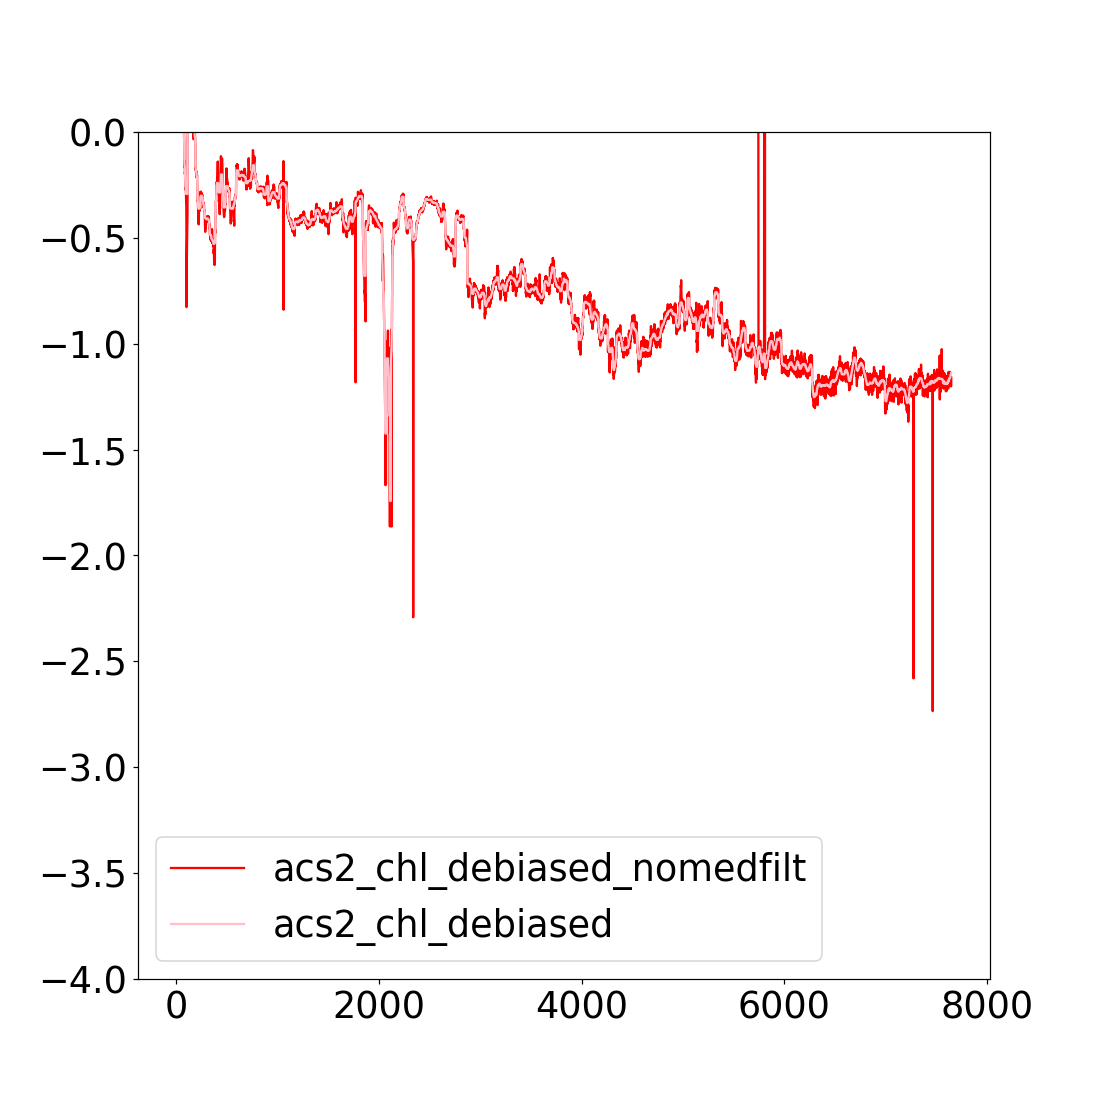

/tmp/ipykernel_556969/3807766989.py:4: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs2_chl_debiased_nomedfilt')


In [154]:
plt.figure(figsize=(10,10))
#plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
#plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values), color='pink', label ='acs_chl_debiased')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs2_chl_debiased_nomedfilt')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values), color='pink', label ='acs2_chl_debiased')
plt.ylim(-4,-0)
plt.legend()

In [144]:
#print(sorted(acs_filtered2.keys()))
#acs_filtered2['hplc_bottle']))




In [146]:
# save updated NetCDF file
acs_filtered2.to_netcdf(DIN_acs + fn_acs[:-3] + '_with_debiased_chl.nc')
acs_filtered2.close()


In [147]:
print(acs_filtered2)

<xarray.Dataset>
Dimensions:                               (time: 38730, acs_wv: 176,
                                           acs2_wv: 176, bb3_wv: 3,
                                           hplc_time: 63)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-09-18T11...
  * acs_wv                                (acs_wv) float64 400.0 402.0 ... 750.0
  * acs2_wv                               (acs2_wv) float64 400.0 ... 750.0
  * bb3_wv                                (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                             (hplc_time) datetime64[ns] 2015-09-...
Data variables: (12/114)
    flow                                  (time) float64 43.69 43.81 ... nan nan
    acs_chl                               (time) float64 2.858 2.858 ... nan nan
    acs_ap                                (time, acs_wv) float64 0.1349 ... nan
    acs_ap_u                              (time, acs_wv) float64 0.005874 ......
    acs_bp                     

<IPython.core.display.Javascript object>


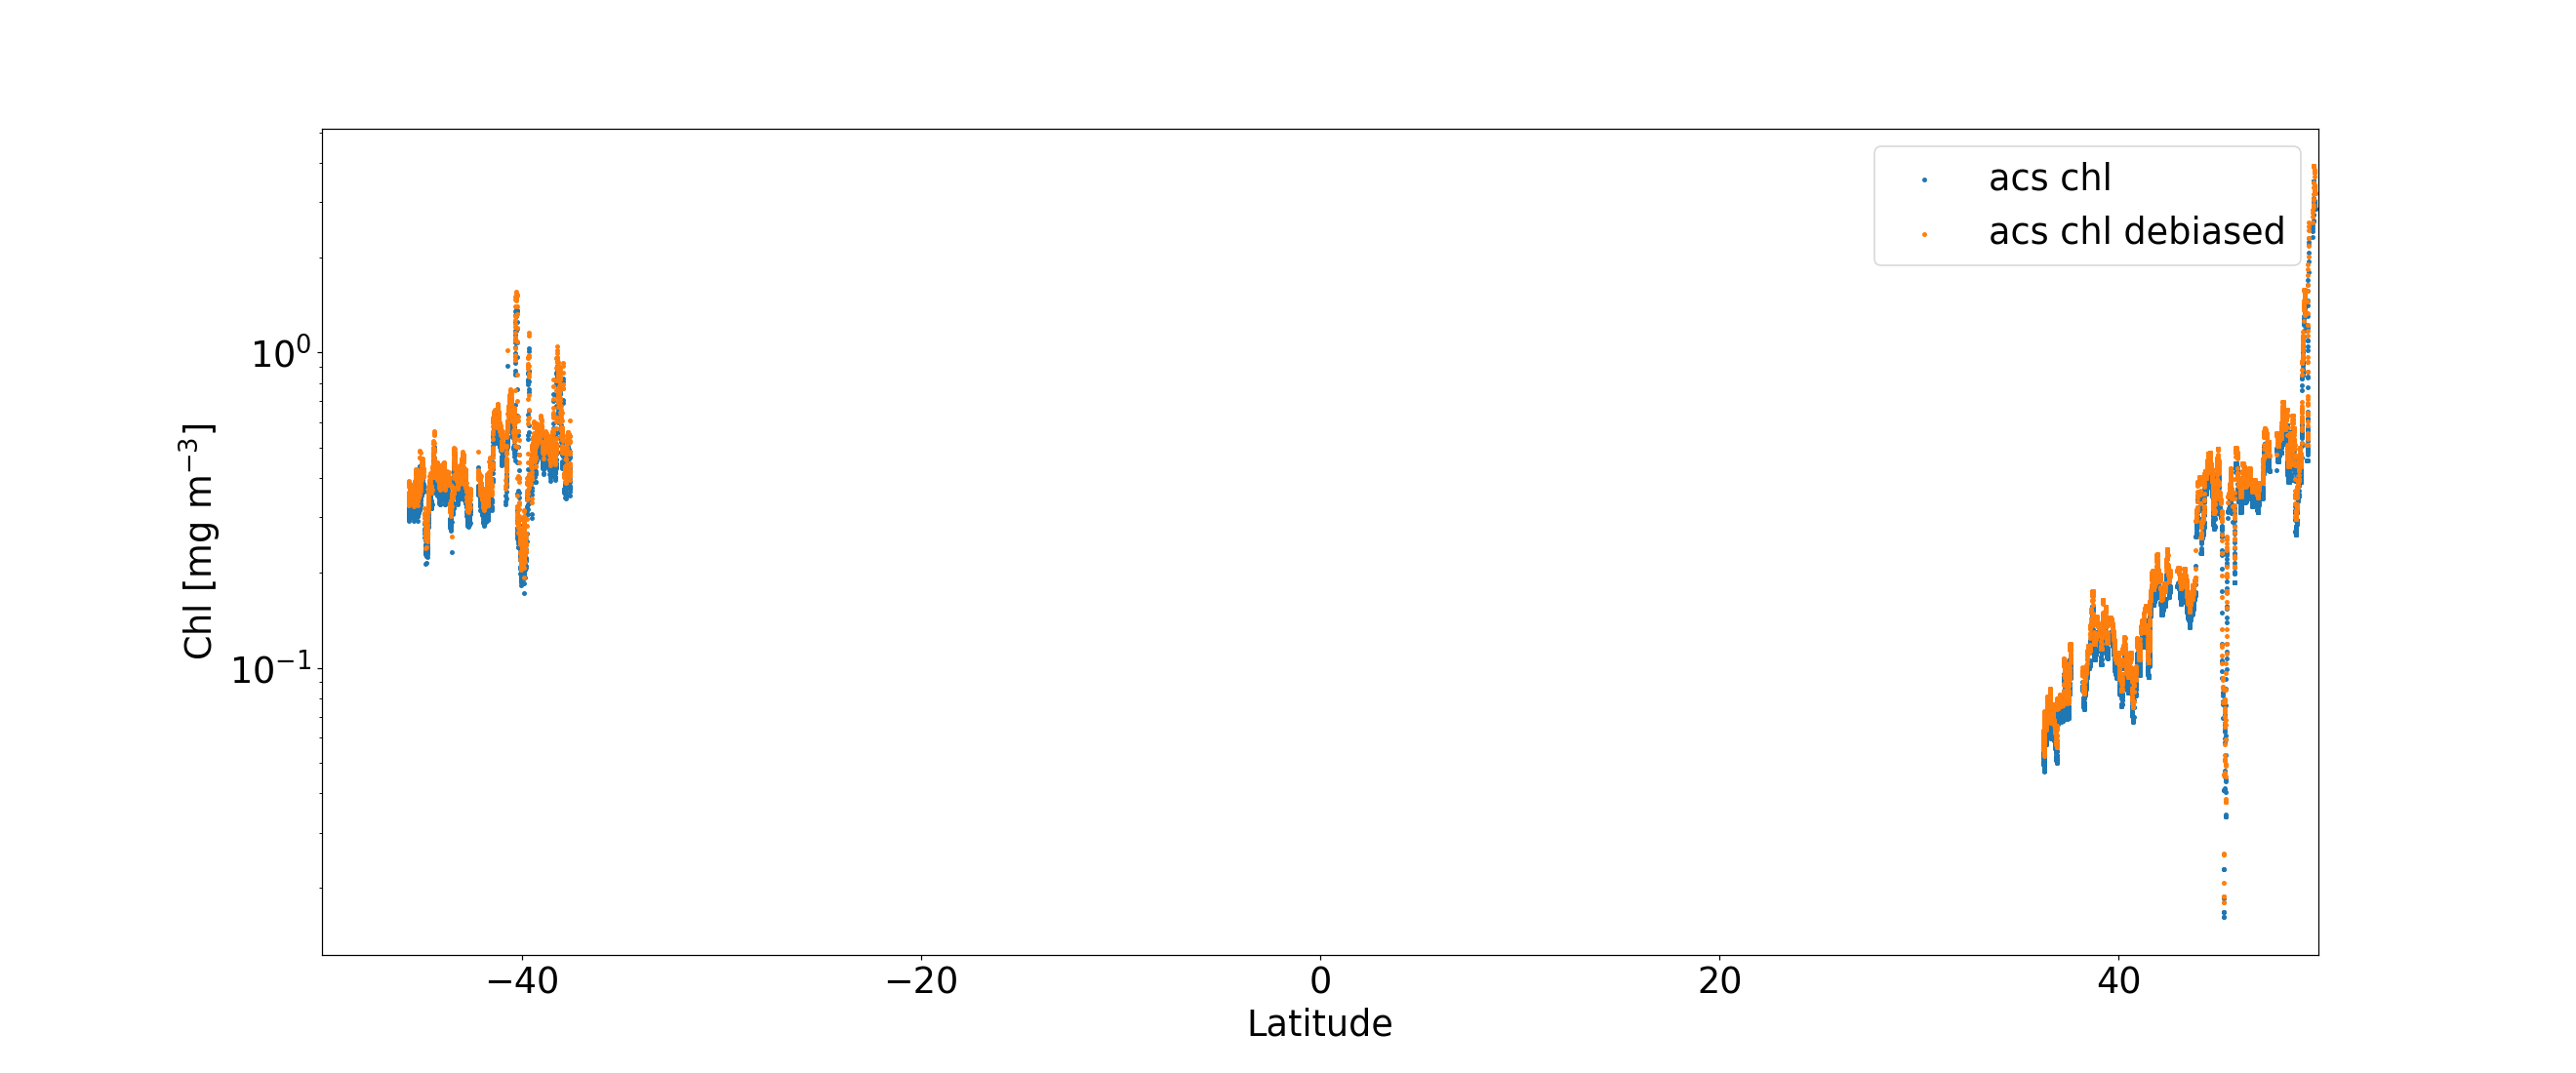

Text(0, 0.5, 'Chl [mg m$^{-3}$]')

In [148]:

# plot to show debiassing of chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl_debiased'], s=5,label='acs chl debiased')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')
    

<IPython.core.display.Javascript object>


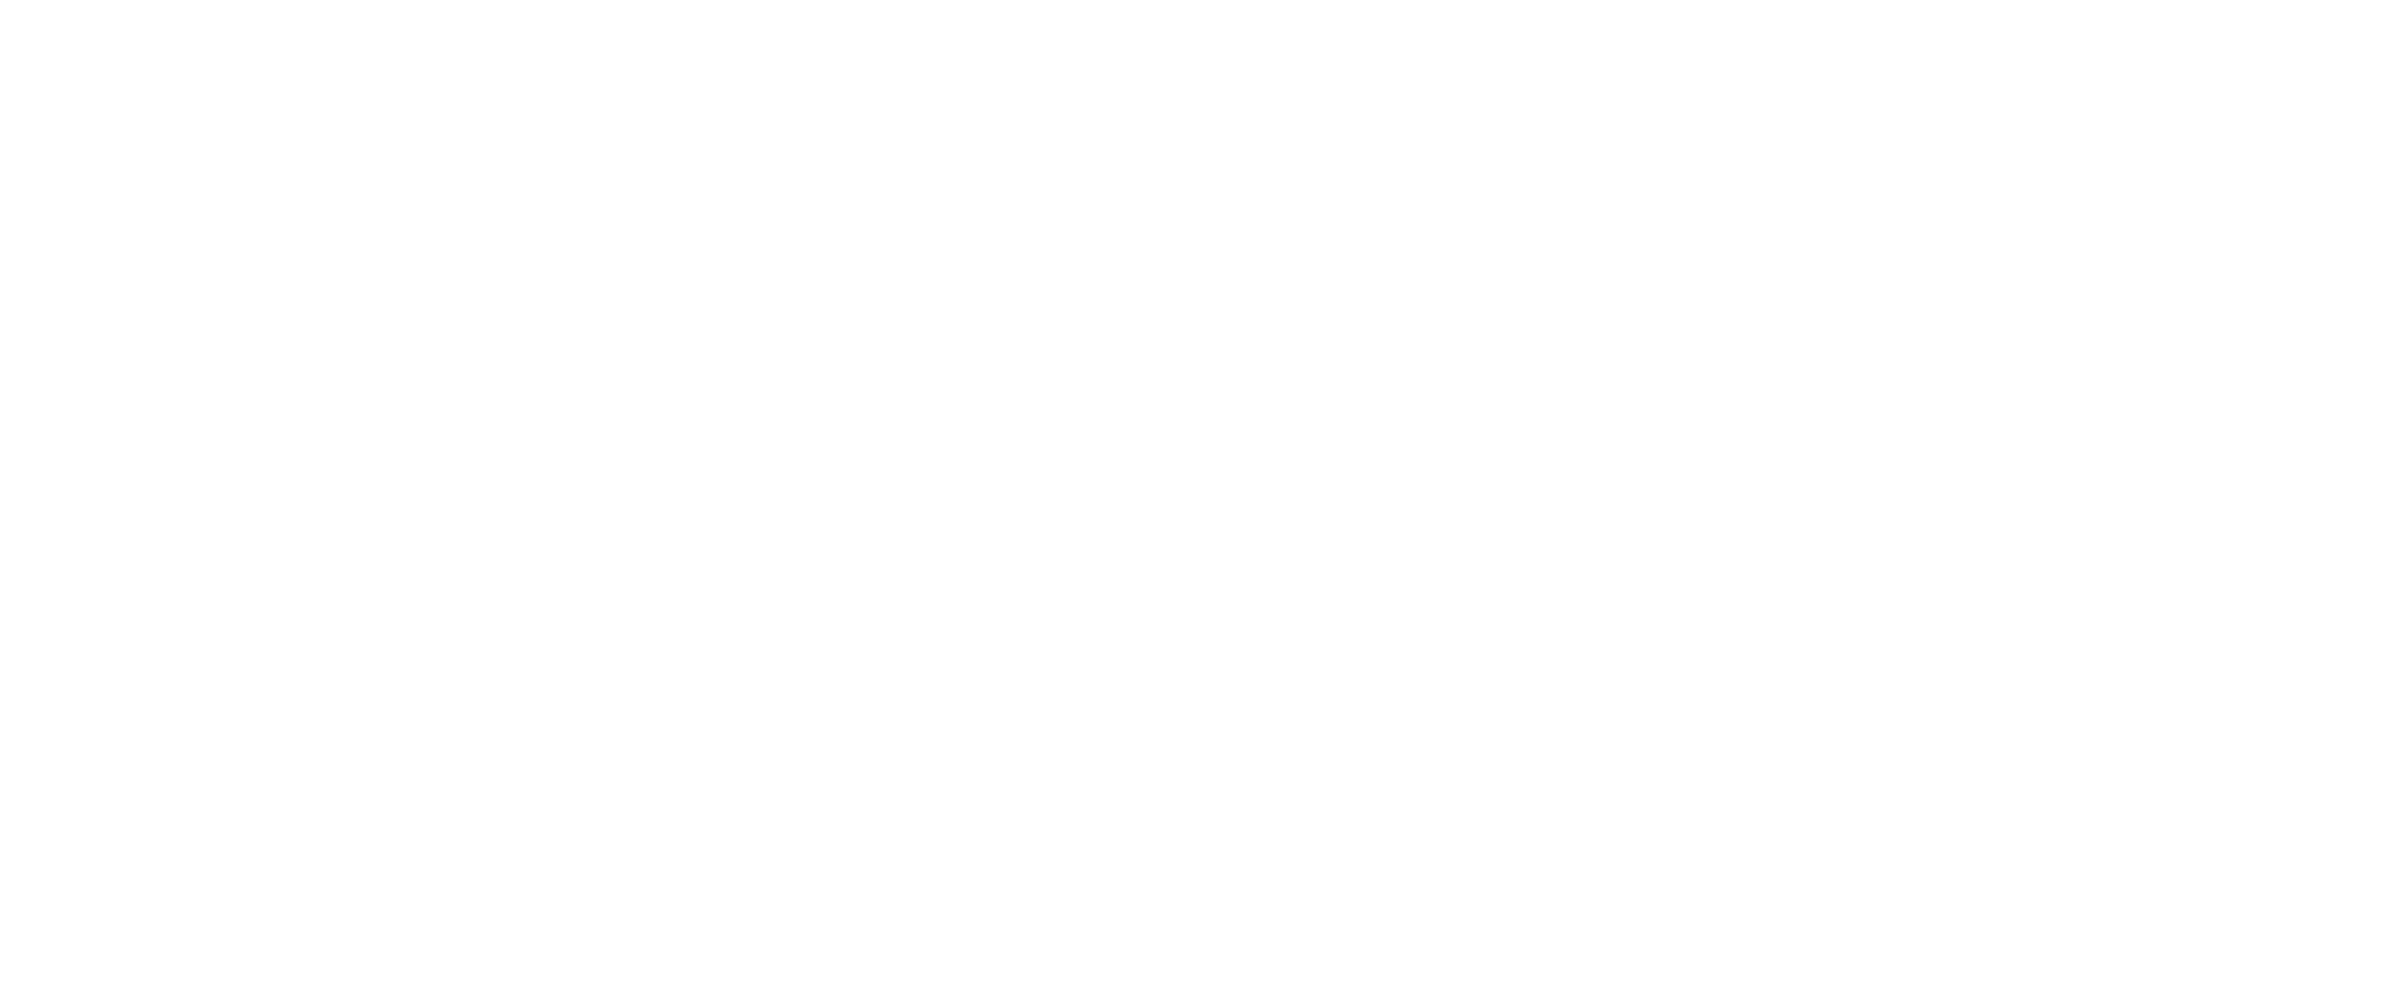

NameError: name 'acs_filtered2' is not defined

In [69]:
# plot to show acs and ac9 chl separately
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['ac9_chl'], s=5,label='ac9 chl')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')

In [ ]:
plt.i
plt.plot(acs_filtered2['acs_chl'])

plt.plot(acs_filtered2['ac9_chl'])

In [ ]:
list(acs_filtered2.keys())